In [ ]:
!pip install scipy
!pip install h5py
!pip install mat73
!pip install scikit-image

Exception ignored in: <function _releaseLock at 0x707dc6e039c0>
Traceback (most recent call last):
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/logging/__init__.py", line 243, in _releaseLock
    def _releaseLock():
    
KeyboardInterrupt: 


- mat73 = like MATLAB’s loadmat() → reads ANY .mat file, converts everything to Python types
- h5py = general HDF5 reader → only works for MATLAB v7.3+ and gives raw datasets

## Load Data

In [1]:
import pathlib
import h5py
import mat73
import numpy as np
from scipy.io import loadmat

def load_iq(iq_file: str, input_var_name="") -> np.ndarray:
    ext = pathlib.Path(iq_file).suffix
    if ext == ".mat":
        # Load IQ.
        try:
            iq = loadmat(iq_file, squeeze_me=True)[input_var_name]
        except NotImplementedError:
            iq = mat73.loadmat(iq_file)[input_var_name]  # If IQ is saved in 7.3.
    elif ext == ".npy":
        iq = np.load(iq_file)

    elif ext == ".npz":
        iq = np.load(iq_file)[input_var_name]

    else:
        raise NotImplementedError(
            f"Loading iq with extension {ext} is not implemented."
        )
    return iq

In [2]:
iq = load_iq("mat/IQ001.mat","IQ")
iq

array([[[[ 1.30376230e+04-6.08059863e+03j,
           1.10074004e+04-2.62143896e+03j,
           8.18771387e+03-7.53524780e+02j, ...,
           8.01292285e+03+4.64324097e+02j,
           7.88180908e+03+7.86389282e+02j,
           7.87551758e+03+6.64253296e+02j],
         [ 1.39978018e+04+4.83288525e+03j,
           1.00142695e+04+4.71429590e+03j,
           6.82043848e+03+3.57435669e+03j, ...,
           5.88096191e+03+3.43586572e+03j,
           5.60827783e+03+3.25742749e+03j,
           5.67676758e+03+3.26338770e+03j],
         [ 3.70971313e+03+1.08935625e+04j,
           1.80286108e+03+6.33944287e+03j,
           1.19392969e+03+2.35523779e+03j, ...,
           1.24459106e+03+1.97788452e+02j,
           1.40515466e+03-2.66952881e+02j,
           1.42094360e+03-1.31360107e+02j],
         ...,
         [ 1.50138994e+04+1.37557803e+04j,
           9.32366699e+03+1.33577275e+04j,
           6.24658643e+03+1.22946074e+04j, ...,
           3.55620117e+03+1.22192656e+04j,
           3.3154

In [1]:
import torch
import numpy as np 
from loguru import logger
import sys

# --- CHECK GPU ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    logger.info(f"CUDA detected: {torch.cuda.get_device_name(0)}")
else:
    logger.warning("No GPU detected. Falling back to CPU (Performance will be low).")
    device = torch.device("cpu")

def euclidean_dist_matrix_torch(A, B):
    """
    Computes Euclidean distance matrix between A and B using broadcasting.
    A: (N, D), B: (M, D) -> Result: (N, M)
    """
    # Using Torch broadcasting
    # A[:, None, :] shape: (N, 1, D)
    # B[None, :, :] shape: (1, M, D)
    diff = A[:, None, :] - B[None, :, :]
    return torch.sqrt(torch.sum(diff**2, dim=-1))

def multiquadric_kernel_torch(dist_matrix, epsilon):
    """ The Multiquadric (MQ) function """
    return torch.sqrt(1 + (epsilon * dist_matrix)**2)

def precompute_rbf_matrices_torch(shape_2d, known_t_indices, epsilon):
    """
    Generates RBF weights entirely on the device.
    shape_2d: (dim_spatial, dim_time_total)
    """
    n_space, n_time = shape_2d
    
    # 1. Generate normalized coordinate grids (0 to 1)
    x_coords = torch.linspace(0, 1, n_space, device=device)
    t_coords = torch.linspace(0, 1, n_time, device=device)
    
    # torch.meshgrid defaults to 'ij' indexing usually, we force 'xy' to match numpy behavior
    T_grid, X_grid = torch.meshgrid(t_coords, x_coords, indexing='xy')
    
    # Flatten and stack: equivalent to np.column_stack
    all_points = torch.stack([X_grid.ravel(), T_grid.ravel()], dim=1)
    
    # 2. Separate into Known and Unknown coordinate sets
    mask = torch.zeros(n_time, dtype=torch.bool, device=device)
    mask[known_t_indices] = True
    
    # Tile the mask: (n_space, n_time)
    mask_2d = mask.tile((n_space, 1))
    
    mask_flat = mask_2d.ravel()
    known_points = all_points[mask_flat]
    unknown_points = all_points[~mask_flat]

    # 3. Build Matrices
    dist_known = euclidean_dist_matrix_torch(known_points, known_points)
    Phi = multiquadric_kernel_torch(dist_known, epsilon)
    
    dist_new = euclidean_dist_matrix_torch(unknown_points, known_points)
    Phi_new = multiquadric_kernel_torch(dist_new, epsilon)
    
    # 4. Compute Inverse (Regularized)
    # Add jitter to diagonal for stability
    jitter = torch.eye(Phi.shape[0], device=device) * 1e-6
    Phi_inv = torch.linalg.inv(Phi + jitter)
    
    W_interp = torch.matmul(Phi_new, Phi_inv)
    
    return W_interp, mask_2d

# --- 1. Batched RBF Helper ---
def apply_batched_rbf(slice_data, W_interp, mask_2d):
    """
    Applies RBF weights to a BATCH of data slices simultaneously.
    
    Args:
        slice_data: (Batch, Width, Time) - Complex Tensor
        W_interp:   (N_unknown, N_known) - Weight Matrix
        mask_2d:    (Width, Time) - Boolean Mask
    
    Returns:
        reconstructed: (Batch, Width, Time)
    """
    if W_interp is None: return slice_data
    
    B, H, W = slice_data.shape
    
    # Flatten spatial/time dims: (Batch, H*W)
    flat_data = slice_data.reshape(B, -1) 
    mask_flat = mask_2d.reshape(-1)
    
    # Extract Known Values: (Batch, N_known)
    # We use boolean indexing. Since mask is 1D and data is 2D, 
    # it broadcasts across the batch dimension correctly.
    known_values = flat_data[:, mask_flat]
    
    # Compute Predictions: (Batch, N_known) @ (N_unknown, N_known).T -> (Batch, N_unknown)
    # Note: We assume W_interp is (N_interp, N_known). We need to transpose it for the matmul.
    predicted_values = torch.matmul(known_values, W_interp.T)
    
    # Reconstruct
    reconstructed_flat = flat_data.clone()
    
    # Fill in the unknown spots
    # Invert mask to get unknown indices
    reconstructed_flat[:, ~mask_flat] = predicted_values
    
    return reconstructed_flat.reshape(B, H, W)

# Helper defined outside to be accessible
def get_edge_matrix_torch(width, T, indices, eps, cache):
    """ Helper to manage the edge cache for odd-sized chunks """
    key = (width, T)
    if key not in cache:
        cache[key] = precompute_rbf_matrices_torch((width, T), indices, eps)
    return cache[key]
# --- 2. Main Batched Function ---
@torch.no_grad()
def run_batched_3x2d_upsampling(batched_data, ups_factor=10, epsilon=10000.0, chunk_size=32, time_block=200):
    """
    Runs 3x2D Upsampling on multiple datasets simultaneously.
    
    Args:
        batched_data: Tensor of shape (Batch, Z, X, Y, T_orig)
    """
    # Ensure input is 5D
    if batched_data.dim() == 4:
        batched_data = batched_data.unsqueeze(0)
    
    # Move to GPU
    if batched_data.device != device:
        batched_data = batched_data.to(device)

    # Unpack Shapes
    Batch, Z, X, Y, T_orig = batched_data.shape
    T_new = T_orig * ups_factor
    
    logger.info(f"Batched Processing | Batch Size: {Batch} | Vol: {Z}x{X}x{Y} | T: {T_orig}->{T_new}")
    
    # 1. Allocate Huge Accumulator (Batch, Z, X, Y, T_new)
    # For 4x 100x100x100x200 (upsampled), this is heavy. ensure 24GB is enough.
    final_accumulator = torch.zeros((Batch, Z, X, Y, T_new), dtype=torch.complex64, device=device)
    
    # 2. Define Time Blocks
    # We split T_new (2000) into blocks of 'time_block' (e.g., 200)
    # The pattern of known frames is identical in each block!
    # Block 1: 0-200, Block 2: 200-400...
    t_starts = range(0, T_new, time_block)
    
    # 3. Pre-compute Matrices for ONE Time Block
    # Since every block has the same structure (every 10th frame known),
    # we calculate the matrix ONCE and reuse it for all time blocks.
    
    # Local indices relative to the block (e.g., 0, 10, 20... inside a 200 window)
    local_known_indices_std = torch.arange(0, time_block, ups_factor, device=device)
    
    # Pass 'device' explicitly to the helper from previous code
    W_std, mask_std = precompute_rbf_matrices_torch(
        (chunk_size, time_block), local_known_indices_std, epsilon
    )
    
    edge_cache = {}

    # --- OUTER LOOP: TIME BLOCKS ---
    for t_idx, t_start in enumerate(t_starts):
        t_end = min(t_start + time_block, T_new)
        current_t_len = t_end - t_start
        t_in_start = t_start // ups_factor
        t_in_end = t_end // ups_factor
        
        local_known_indices_curr = torch.arange(0, current_t_len, ups_factor, device=device)

        def get_matrix_for_strip(width):
            if width == chunk_size and current_t_len == time_block:
                return W_std, mask_std
            else:
                return get_edge_matrix_torch(width, current_t_len, local_known_indices_curr, epsilon, edge_cache)

        # --- BATCHED STRIP PROCESSOR ---
        def process_batched_strip(dim_type, indices, W_matrix, Mask_matrix):
            # 1. Extract Raw Data with Batch Dimension
            # Slicing: [All Batches, Specific Spatial Slice, Time Slice]
            if dim_type == 'xt':
                z, y, s, e = indices
                raw_device = batched_data[:, z, s:e, y, t_in_start:t_in_end] # (B, Width, T_in)
            elif dim_type == 'yt':
                z, x, s, e = indices
                raw_device = batched_data[:, z, x, s:e, t_in_start:t_in_end]
            elif dim_type == 'zt':
                y, x, s, e = indices
                raw_device = batched_data[:, s:e, x, y, t_in_start:t_in_end]
            
            # 2. Map to Sparse Grid
            strip_width = indices[3] - indices[2]
            strip_shape = (Batch, strip_width, current_t_len)
            
            strip_device = torch.zeros(strip_shape, dtype=torch.complex64, device=device)
            valid_idx = torch.arange(0, current_t_len, ups_factor, device=device)
            
            # Broadcast assignment
            strip_device[:, :, valid_idx] = raw_device
            
            # 3. Compute (Batched RBF)
            rec_real = apply_batched_rbf(strip_device.real, W_matrix, Mask_matrix)
            rec_imag = apply_batched_rbf(strip_device.imag, W_matrix, Mask_matrix)
            
            return torch.complex(rec_real, rec_imag)

        # --- PASS 1: X-T Plane ---
        for z in range(Z):
            for y in range(Y):
                for x_start in range(0, X, chunk_size):
                    x_end = min(x_start + chunk_size, X)
                    w = x_end - x_start
                    W, M = get_matrix_for_strip(w)
                    
                    rec = process_batched_strip('xt', [z, y, x_start, x_end], W, M)
                    
                    # Accumulate into Batch
                    final_accumulator[:, z, x_start:x_end, y, t_start:t_end] += rec

        # --- PASS 2: Y-T Plane ---
        for z in range(Z):
            for x in range(X):
                for y_start in range(0, Y, chunk_size):
                    y_end = min(y_start + chunk_size, Y)
                    w = y_end - y_start
                    W, M = get_matrix_for_strip(w)
                    
                    rec = process_batched_strip('yt', [z, x, y_start, y_end], W, M)
                    final_accumulator[:, z, x, y_start:y_end, t_start:t_end] += rec

        # --- PASS 3: Z-T Plane ---
        for y in range(Y):
            for x in range(X):
                for z_start in range(0, Z, chunk_size):
                    z_end = min(z_start + chunk_size, Z)
                    w = z_end - z_start
                    W, M = get_matrix_for_strip(w)
                    
                    rec = process_batched_strip('zt', [y, x, z_start, z_end], W, M)
                    final_accumulator[:, z_start:z_end, x, y, t_start:t_end] += rec

        logger.info(f"Finished Time Block {t_start}-{t_end}")

    final_accumulator /= 3.0
    return final_accumulator

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2025-12-26 16:44:39.718 | INFO     | __main__:<module>:9 - CUDA detected: NVIDIA L4


In [4]:
def validate_batched_reconstruction(batched_iq_data, ds, time_blk=200):
    """
    Robust validation for Batched 4D data (5D Tensor).
    Input Shape: (Batch, Z, X, Y, T)
    Calculates global metrics across the entire batch.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Ensure Input is Tensor on Device
    if not torch.is_tensor(batched_iq_data):
        batched_iq_data = torch.from_numpy(batched_iq_data)
    
    # Handle 4D input (Single Dataset) by unsqueezing to 5D
    if batched_iq_data.dim() == 4:
        batched_iq_data = batched_iq_data.unsqueeze(0)
        
    if batched_iq_data.device != device:
        batched_iq_data = batched_iq_data.to(device)

    # Get shapes: (Batch, Z, X, Y, T_full)
    Batch, Z, X, Y, T_full = batched_iq_data.shape
    
    # 2. Decimate (Slice along Time dimension for all batches)
    decimated_data = batched_iq_data[..., ::ds] 
    
    # 3. Run Batched Reconstruction
    # Note: We do NOT use [0] here because we want the full batch output
    print(f"Validating Batch of {Batch} datasets with Downsample Factor {ds}...")
    reconstructed_batch = run_batched_3x2d_upsampling(
        decimated_data, 
        ups_factor=ds, 
        time_block=time_blk
    )
    
    # 4. Align Time Dimensions
    T_rec = reconstructed_batch.shape[-1]
    min_T = min(T_full, T_rec)
    
    # Crop both to the same valid time range
    truth_cropped = batched_iq_data[..., :min_T]
    pred_cropped = reconstructed_batch[..., :min_T]
    
    # 5. Identify  run_batched_3x2d_upsampling(bat_input)Missing (Interpolated) Frames
    # We only want to score the frames that were NOT in the input
    known_indices = torch.arange(0, min_T, ds, device=device)
    mask_missing = torch.ones(min_T, dtype=torch.bool, device=device)
    mask_missing[known_indices] = False
    # MSE & RMSE
    mse = torch.mean(torch.abs(error_diff)**2)
    rmse = torch.sqrt(mse)
    
    # 6. Extract Missing Frames
    # Applying mask to the last dimension (Time)
    # Result shape: (Batch, Z, X, Y, N_interpolated_frames)
    ground_truth_frames = truth_cropped[..., mask_missing]
    predicted_frames = pred_cropped[..., mask_missing]
    
    # 7. Metrics (Computed Globally across the Batch)
    error_diff = predicted_frames - ground_truth_frames
    
    # MSE & RMSE
    mse = torch.mean(torch.abs(error_diff)**2)
    rmse = torch.sqrt(mse)
    
    # NRMSE (Normalized by the global range of the batch)
    # If datasets have vastly different dynamic ranges, consider calculating NRMSE per batch item instead.
    global_max = torch.max(torch.abs(ground_truth_frames))
    global_min = torch.min(torch.abs(ground_truth_frames))
    data_range = global_max - global_min
    
    nrmse = rmse / data_range if data_range != 0 else torch.tensor(0.0)
    
    # Correlation
    # Flatten entire batch to 1D vectors
    flat_true = torch.abs(ground_truth_frames).reshape(-1)
    flat_pred = torch.abs(predicted_frames).reshape(-1)
    
    stacked = torch.stack((flat_true, flat_pred))
    correlation = torch.corrcoef(stacked)[0, 1]
    
    print(f"--- Batched Validation Results (ds={ds}) ---")
    print(f"Total Interpolated Frames Evaluated: {flat_true.shape[0]}")
    print(f"Global NRMSE Error: {nrmse.item():.4f}")
    print(f"Global Correlation: {correlation.item():.4f}")
    
    # Optional: Return data on CPU to save VRAM
    return ground_truth_frames.cpu(), predicted_frames.cpu()

In [1]:
import pathlib
import h5py
import mat73
import numpy as np
import torch
from scipy.io import loadmat

def load_iq(iq_file: str, input_var_name="IQ") -> np.ndarray:
    ext = pathlib.Path(iq_file).suffix
    if ext == ".mat":
        # Load IQ.
        try:
            iq = loadmat(iq_file, squeeze_me=True)[input_var_name]
        except NotImplementedError:
            iq = mat73.loadmat(iq_file)[input_var_name]  # If IQ is saved in 7.3.
    elif ext == ".npy":
        iq = np.load(iq_file)

    elif ext == ".npz":
        iq = np.load(iq_file)[input_var_name]

    else:
        raise NotImplementedError(
            f"Loading iq with extension {ext} is not implemented."
        )
    return iq
n = 4
dataset_list = []
for i in range(n):
    file_name = f"mat/IQ00{i+1}.mat"
    iq = load_iq(file_name,"IQ")
    dataset_list.append(iq)
bat_input = torch.stack([torch.from_numpy(d) for d in dataset_list])
bat_input.shape

torch.Size([4, 68, 65, 70, 200])

In [ ]:
import torch
import numpy as np
from loguru import logger
import sys

# --- CHECK GPU ---
if torch.cuda.is_available():
    device = torch.device("cuda")
    logger.info(f"CUDA detected: {torch.cuda.get_device_name(0)}")
else:
    logger.warning("No GPU detected.")
    device = torch.device("cpu")

# --- RBF KERNEL FUNCTIONS (Unchanged logic, just helpers) ---
def euclidean_dist_matrix_torch(A, B):
    diff = A[:, None, :] - B[None, :, :]
    return torch.sqrt(torch.sum(diff**2, dim=-1))

def multiquadric_kernel_torch(dist_matrix, epsilon):
    return torch.sqrt(1 + (epsilon * dist_matrix)**2)

def precompute_rbf_matrices_torch(shape_2d, known_t_indices, epsilon):
    """
    Generates RBF weights.
    shape_2d: (dim_spatial, dim_time_total)
    """
    n_space, n_time = shape_2d
    
    # Grid generation
    x_coords = torch.linspace(0, 1, n_space, device=device)
    t_coords = torch.linspace(0, 1, n_time, device=device)
    T_grid, X_grid = torch.meshgrid(t_coords, x_coords, indexing='xy')
    all_points = torch.stack([X_grid.ravel(), T_grid.ravel()], dim=1)
    
    # Masking
    mask = torch.zeros(n_time, dtype=torch.bool, device=device)
    mask[known_t_indices] = True
    mask_2d = mask.tile((n_space, 1))
    
    mask_flat = mask_2d.ravel()
    known_points = all_points[mask_flat]
    unknown_points = all_points[~mask_flat]

    # Matrices
    dist_known = euclidean_dist_matrix_torch(known_points, known_points)
    Phi = multiquadric_kernel_torch(dist_known, epsilon)
    
    dist_new = euclidean_dist_matrix_torch(unknown_points, known_points)
    Phi_new = multiquadric_kernel_torch(dist_new, epsilon)
    
    # Inverse with jitter
    jitter = torch.eye(Phi.shape[0], device=device) * 1e-6
    Phi_inv = torch.linalg.inv(Phi + jitter)
    
    W_interp = torch.matmul(Phi_new, Phi_inv)
    return W_interp, mask_2d

def apply_vectorized_rbf(flat_data, W_interp, mask_2d):
    """
    Applies RBF to a massively flattened batch.
    flat_data: (Big_Batch, Spatial * Time)
    W_interp: (N_unknown, N_known)
    """
    if W_interp is None: return flat_data

    # Shapes
    B_total = flat_data.shape[0]
    mask_flat = mask_2d.reshape(-1) # (Spatial*Time)
    
    # 1. Extract Known Values
    # flat_data is (B, N_points). mask_flat is (N_points).
    # Boolean indexing selects columns: result (B, N_known)
    known_values = flat_data[:, mask_flat]
    
    # 2. Matrix Multiplication
    # (B, N_known) @ (N_unknown, N_known).T -> (B, N_unknown)
    predicted_values = torch.matmul(known_values, W_interp.T)
    
    # 3. Reconstruction
    # Clone to avoid overwriting input if needed (safer for gradients/views)
    out_data = flat_data.clone()
    
    # Assign back to unknown slots
    # We cannot use simple boolean indexing for assignment on the flattened 2D tensor easily 
    # without advanced indexing. 
    # out_data[:, ~mask_flat] = predicted_values works efficiently in PyTorch.
    out_data[:, ~mask_flat] = predicted_values
    
    return out_data

def get_cached_matrix(width, time_len, indices, eps, cache):
    key = (width, time_len)
    if key not in cache:
        cache[key] = precompute_rbf_matrices_torch((width, time_len), indices, eps)
    return cache[key]

# --- MAIN OPTIMIZED FUNCTION ---
@torch.no_grad()
def run_fast_upsampling(batched_data, ups_factor=10, epsilon=10000.0, time_block=200):
    """
    Vectorized 3x2D Upsampling.
    Removes spatial loops by treating dimensions as batch items.
    """
    # 1. Setup Data
    if not torch.is_tensor(batched_data):
        batched_data = torch.from_numpy(batched_data)
    if batched_data.dim() == 4:
        batched_data = batched_data.unsqueeze(0)
    
    batched_data = batched_data.to(device)
    
    Batch, Z, X, Y, T_orig = batched_data.shape
    T_new = T_orig * ups_factor
    
    logger.info(f"Fast Processing | Shape: {Batch}x{Z}x{X}x{Y} | T: {T_orig}->{T_new}")

    # 2. Allocate Accumulator (10GB for 2000 frames)
    # 
    # final_accumulator = torch.zeros((Batch, Z, X, Y, T_new), dtype=torch.complex64, device=device)
    final_accumulator_cpu = torch.zeros(
        (Batch, Z, X, Y, T_new), 
        dtype=torch.complex64, 
        device='cpu', 
        pin_memory=True 
    )
    
    # 3. Setup Time Blocks
    t_starts = range(0, T_new, time_block)
    
    # Cache for RBF matrices (X, Y, Z might differ in size)
    matrix_cache = {}
    
    # --- OUTER LOOP: TIME BLOCKS ONLY ---
    for t_start in t_starts:
        t_end = min(t_start + time_block, T_new)
        curr_t_len = t_end - t_start
        t_in_start = t_start // ups_factor
        t_in_end = t_end // ups_factor
        
        # Shape: (B, Z, X, Y, curr_t_len) - Much smaller than full volume
        block_accumulator_gpu = torch.zeros(
            (Batch, Z, X, Y, curr_t_len), 
            dtype=torch.complex64, 
            device=device
        )
        
        # Extract small time slice from input: (B, Z, X, Y, T_small)
        # We need to handle edge case where input slice might be smaller at the very end
        t_in_slice = batched_data[..., t_in_start:t_in_end]
        
        # Calculate indices for this block
        local_indices = torch.arange(0, curr_t_len, ups_factor, device=device)

        # --- PASS 1: X-T Plane ---
        # We want to interpolate X-T. Treat (B, Z, Y) as batch.
        # Permute to: (B, Z, Y, X, T)
        # Reshape to: (B*Z*Y, X*T)
        input_view_xt = t_in_slice.permute(0, 1, 3, 2, 4).reshape(-1, X * (t_in_end - t_in_start))
        
        # Check cache / Precompute Matrix for dimension X
        W, M = get_cached_matrix(X, curr_t_len, local_indices, epsilon, matrix_cache)
        
        # Prepare Sparse Grid (B_total, X * T_large)
        sparse_grid = torch.zeros((input_view_xt.shape[0], X * curr_t_len), dtype=torch.complex64, device=device)
        
        # Map input to sparse grid
        # We need to construct a mask mapping input pixels to output pixels
        # M is (X, T_new). M.ravel() has True at known locations.
        # We just copy directly using the known mask logic
        valid_mask_flat = M.reshape(-1) # (X * T_large)
        sparse_grid[:, valid_mask_flat] = input_view_xt
        
        # Run RBF
        rec_real = apply_vectorized_rbf(sparse_grid.real, W, M)
        rec_imag = apply_vectorized_rbf(sparse_grid.imag, W, M)
        rec_xt = torch.complex(rec_real, rec_imag)
        
        # Reshape and Add to Accumulator
        # Shape back to: (B, Z, Y, X, T) -> Permute back to (B, Z, X, Y, T)
        rec_xt = rec_xt.reshape(Batch, Z, Y, X, curr_t_len).permute(0, 1, 3, 2, 4)
        block_accumulator_gpu += rec_xt
        del rec_xt, input_view_xt, sparse_grid, rec_real, rec_imag

        # --- PASS 2: Y-T Plane ---
        # Active: Y, T. Batch: B, Z, X.
        # Permute to: (B, Z, X, Y, T) -> This is natural order!
        # Reshape to: (B*Z*X, Y*T)
        input_view_yt = t_in_slice.reshape(-1, Y * (t_in_end - t_in_start))
        
        W, M = get_cached_matrix(Y, curr_t_len, local_indices, epsilon, matrix_cache)
        
        sparse_grid = torch.zeros((input_view_yt.shape[0], Y * curr_t_len), dtype=torch.complex64, device=device)
        valid_mask_flat = M.reshape(-1)
        sparse_grid[:, valid_mask_flat] = input_view_yt
        
        rec_real = apply_vectorized_rbf(sparse_grid.real, W, M)
        rec_imag = apply_vectorized_rbf(sparse_grid.imag, W, M)
        rec_yt = torch.complex(rec_real, rec_imag)
        
        # Reshape: (B, Z, X, Y, T) -> Natural order, no permute needed
        rec_yt = rec_yt.reshape(Batch, Z, X, Y, curr_t_len)
        block_accumulator_gpu += rec_yt
        
        del rec_yt, input_view_yt, sparse_grid, rec_real, rec_imag

        # --- PASS 3: Z-T Plane ---
        # Active: Z, T. Batch: B, X, Y.
        # Permute to: (B, X, Y, Z, T)
        input_view_zt = t_in_slice.permute(0, 2, 3, 1, 4).reshape(-1, Z * (t_in_end - t_in_start))
        
        W, M = get_cached_matrix(Z, curr_t_len, local_indices, epsilon, matrix_cache)
        
        sparse_grid = torch.zeros((input_view_zt.shape[0], Z * curr_t_len), dtype=torch.complex64, device=device)
        valid_mask_flat = M.reshape(-1)
        sparse_grid[:, valid_mask_flat] = input_view_zt
        
        rec_real = apply_vectorized_rbf(sparse_grid.real, W, M)
        rec_imag = apply_vectorized_rbf(sparse_grid.imag, W, M)
        rec_zt = torch.complex(rec_real, rec_imag)
        
        # Reshape: (B, X, Y, Z, T) -> Permute to (B, Z, X, Y, T)
        rec_zt = rec_zt.reshape(Batch, X, Y, Z, curr_t_len).permute(0, 3, 1, 2, 4)
        block_accumulator_gpu += rec_zt
        
        del rec_zt, input_view_zt, sparse_grid, rec_real, rec_imag

        # [NEW] Normalize, Offload to CPU, and Flush GPU Memory
        block_accumulator_gpu /= 3.0
        final_accumulator_cpu[..., t_start:t_end] = block_accumulator_gpu.cpu()
        
        del block_accumulator_gpu
        torch.cuda.empty_cache() # Crucial: Return freed memory to OS/Allocator
        
        logger.debug(f"Time Block {t_start}-{t_end} processed.")

    final_accumulator_cpu /= 3.0

/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/site-packages/torch/cuda/__init__.py:827: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2025-12-26 17:03:19.436 | INFO     | __main__:<module>:10 - CUDA detected: NVIDIA L4


In [8]:
torch.cuda.empty_cache()


In [25]:
import gc
gc.collect()

448

In [ ]:
4*68

In [7]:
rec = run_fast_upsampling(bat_input[:4])

2025-12-26 17:06:40.072 | INFO     | __main__:run_fast_upsampling:118 - Fast Processing | Shape: 4x68x65x70 | T: 200->2000


AcceleratorError: CUDA error: out of memory
Search for `cudaErrorMemoryAllocation' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [4]:
rec

tensor([[[[[ 4.3459e+03-2.0269e+03j,  4.5660e+03-1.7785e+03j,
             4.6723e+03-1.5293e+03j,  ...,
             2.8025e+03+6.4516e+02j,  2.7715e+03+6.3157e+02j,
             2.7373e+03+6.0998e+02j],
           [ 4.6659e+03+1.6110e+03j,  4.6296e+03+2.0002e+03j,
             4.4655e+03+2.2620e+03j,  ...,
             1.4082e+03+9.5815e+02j,  1.3368e+03+8.4921e+02j,
             1.2820e+03+7.4013e+02j],
           [ 1.2366e+03+3.6312e+03j,  1.1603e+03+3.5270e+03j,
             1.0365e+03+3.3327e+03j,  ...,
             9.4343e+02-4.3911e+02j,  9.6823e+02-5.1173e+02j,
             9.9531e+02-5.7614e+02j],
           ...,
           [ 5.0046e+03+4.5853e+03j,  4.5014e+03+5.0233e+03j,
             4.0556e+03+5.2373e+03j,  ...,
             6.5630e+02+4.1502e+03j,  7.3621e+02+4.0621e+03j,
             8.1171e+02+3.9850e+03j],
           [ 6.9729e+03+8.2839e+02j,  6.6084e+03+1.5727e+03j,
             6.2177e+03+2.1068e+03j,  ...,
             1.7488e+03+4.1051e+03j,  1.7997e+03+4.0034e+03

In [11]:
rec.requires_grad

False

In [1]:
del rec

NameError: name 'rec' is not defined

In [7]:
rec

tensor([[[[[ 1.3038e+04-6.0806e+03j,  1.3698e+04-5.3355e+03j,
             1.4017e+04-4.5879e+03j,  ...,
             8.4075e+03+1.9355e+03j,  8.3145e+03+1.8947e+03j,
             8.2120e+03+1.8299e+03j],
           [ 1.3998e+04+4.8329e+03j,  1.3889e+04+6.0005e+03j,
             1.3397e+04+6.7859e+03j,  ...,
             4.2247e+03+2.8745e+03j,  4.0103e+03+2.5476e+03j,
             3.8460e+03+2.2204e+03j],
           [ 3.7097e+03+1.0894e+04j,  3.4808e+03+1.0581e+04j,
             3.1096e+03+9.9980e+03j,  ...,
             2.8303e+03-1.3173e+03j,  2.9047e+03-1.5352e+03j,
             2.9859e+03-1.7284e+03j],
           ...,
           [ 1.5014e+04+1.3756e+04j,  1.3504e+04+1.5070e+04j,
             1.2167e+04+1.5712e+04j,  ...,
             1.9689e+03+1.2451e+04j,  2.2086e+03+1.2186e+04j,
             2.4351e+03+1.1955e+04j],
           [ 2.0919e+04+2.4852e+03j,  1.9825e+04+4.7180e+03j,
             1.8653e+04+6.3204e+03j,  ...,
             5.2465e+03+1.2315e+04j,  5.3991e+03+1.2010e+04

In [8]:
bat_input

tensor([[[[[ 1.3038e+04-6.0806e+03j,  1.1007e+04-2.6214e+03j,
             8.1877e+03-7.5352e+02j,  ...,
             8.0129e+03+4.6432e+02j,  7.8818e+03+7.8639e+02j,
             7.8755e+03+6.6425e+02j],
           [ 1.3998e+04+4.8329e+03j,  1.0014e+04+4.7143e+03j,
             6.8204e+03+3.5744e+03j,  ...,
             5.8810e+03+3.4359e+03j,  5.6083e+03+3.2574e+03j,
             5.6768e+03+3.2634e+03j],
           [ 3.7097e+03+1.0894e+04j,  1.8029e+03+6.3394e+03j,
             1.1939e+03+2.3552e+03j,  ...,
             1.2446e+03+1.9779e+02j,  1.4052e+03-2.6695e+02j,
             1.4209e+03-1.3136e+02j],
           ...,
           [ 1.5014e+04+1.3756e+04j,  9.3237e+03+1.3358e+04j,
             6.2466e+03+1.2295e+04j,  ...,
             3.5562e+03+1.2219e+04j,  3.3154e+03+1.2336e+04j,
             3.4566e+03+1.2470e+04j],
           [ 2.0919e+04+2.4852e+03j,  1.4137e+04+8.0884e+03j,
             9.4611e+03+1.0366e+04j,  ...,
             5.3954e+03+1.2004e+04j,  5.2397e+03+1.2227e+04

In [6]:
rec.shape

torch.Size([2, 68, 65, 70, 2000])

In [5]:
rec

tensor([[[[[ 1.3038e+04-6.0806e+03j,  1.3698e+04-5.3355e+03j,
             1.4017e+04-4.5879e+03j,  ...,
             8.4075e+03+1.9355e+03j,  8.3145e+03+1.8947e+03j,
             8.2120e+03+1.8299e+03j],
           [ 1.3998e+04+4.8329e+03j,  1.3889e+04+6.0005e+03j,
             1.3397e+04+6.7859e+03j,  ...,
             4.2247e+03+2.8745e+03j,  4.0103e+03+2.5476e+03j,
             3.8460e+03+2.2204e+03j],
           [ 3.7097e+03+1.0894e+04j,  3.4808e+03+1.0581e+04j,
             3.1096e+03+9.9980e+03j,  ...,
             2.8303e+03-1.3173e+03j,  2.9047e+03-1.5352e+03j,
             2.9859e+03-1.7284e+03j],
           ...,
           [ 1.5014e+04+1.3756e+04j,  1.3504e+04+1.5070e+04j,
             1.2167e+04+1.5712e+04j,  ...,
             1.9689e+03+1.2451e+04j,  2.2086e+03+1.2186e+04j,
             2.4351e+03+1.1955e+04j],
           [ 2.0919e+04+2.4852e+03j,  1.9825e+04+4.7180e+03j,
             1.8653e+04+6.3204e+03j,  ...,
             5.2465e+03+1.2315e+04j,  5.3991e+03+1.2010e+04

In [22]:
truth, pred = validate_batched_reconstruction(bat_input, ds=2)

2025-12-26 16:29:19.266 | INFO     | __main__:run_fast_upsampling:117 - Fast Processing | Shape: 3x68x65x70 | T: 100->200


Validating Batch of 3 datasets with Downsample Factor 2...
65
torch.Size([14280, 6500])
torch.Size([6500, 6500])
torch.Size([6500, 6500])
torch.Size([7000, 7000])
torch.Size([7000, 7000])
torch.Size([6800, 6800])
torch.Size([6800, 6800])


2025-12-26 16:29:21.093 | DEBUG    | __main__:run_fast_upsampling:213 - Time Block 0-200 processed.


--- Batched Validation Results (ds=2) ---
Total Interpolated Frames Evaluated: 92820000
Global NRMSE Error: 0.0013
Global Correlation: 0.9998


In [2]:
def validate_batched_reconstruction(batched_iq_data, ds, time_blk=200):
    """
    Robust validation for Batched 4D data (5D Tensor).
    Input Shape: (Batch, Z, X, Y, T)
    Calculates global metrics across the entire batch.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Ensure Input is Tensor on Device
    if not torch.is_tensor(batched_iq_data):
        batched_iq_data = torch.from_numpy(batched_iq_data)
    
    # Handle 4D input (Single Dataset) by unsqueezing to 5D
    if batched_iq_data.dim() == 4:
        batched_iq_data = batched_iq_data.unsqueeze(0)
        
    if batched_iq_data.device != device:
        batched_iq_data = batched_iq_data.to(device)

    # Get shapes: (Batch, Z, X, Y, T_full)
    Batch, Z, X, Y, T_full = batched_iq_data.shape
    
    # 2. Decimate (Slice along Time dimension for all batches)
    decimated_data = batched_iq_data[..., ::ds] 
    
    # 3. Run Batched Reconstruction
    # Note: We do NOT use [0] here because we want the full batch output
    print(f"Validating Batch of {Batch} datasets with Downsample Factor {ds}...")
    reconstructed_batch = run_fast_upsampling(
        decimated_data, 
        ups_factor=ds, 
        time_block=time_blk
    )
    
    # 4. Align Time Dimensions
    T_rec = reconstructed_batch.shape[-1]
    min_T = min(T_full, T_rec)
    
    # Crop both to the same valid time range
    truth_cropped = batched_iq_data[..., :min_T]
    pred_cropped = reconstructed_batch[..., :min_T]
    
    # 5. Identify  run_batched_3x2d_upsampling(bat_input)Missing (Interpolated) Frames
    # We only want to score the frames that were NOT in the input
    known_indices = torch.arange(0, min_T, ds, device=device)
    mask_missing = torch.ones(min_T, dtype=torch.bool, device=device)
    mask_missing[known_indices] = False
    
    # 6. Extract Missing Frames
    # Applying mask to the last dimension (Time)
    # Result shape: (Batch, Z, X, Y, N_interpolated_frames)
    ground_truth_frames = truth_cropped[..., mask_missing]
    predicted_frames = pred_cropped[..., mask_missing]
    
    # 7. Metrics (Computed Globally across the Batch)
    error_diff = predicted_frames - ground_truth_frames
    
    # MSE & RMSE
    mse = torch.mean(torch.abs(error_diff)**2)
    rmse = torch.sqrt(mse)
    
    # NRMSE (Normalized by the global range of the batch)
    # If datasets have vastly different dynamic ranges, consider calculating NRMSE per batch item instead.
    global_max = torch.max(torch.abs(ground_truth_frames))
    global_min = torch.min(torch.abs(ground_truth_frames))
    data_range = global_max - global_min
    
    nrmse = rmse / data_range if data_range != 0 else torch.tensor(0.0)
    
    # Correlation
    # Flatten entire batch to 1D vectors
    flat_true = torch.abs(ground_truth_frames).reshape(-1)
    flat_pred = torch.abs(predicted_frames).reshape(-1)
    
    stacked = torch.stack((flat_true, flat_pred))
    correlation = torch.corrcoef(stacked)[0, 1]
    
    print(f"--- Batched Validation Results (ds={ds}) ---")
    print(f"Total Interpolated Frames Evaluated: {flat_true.shape[0]}")
    print(f"Global NRMSE Error: {nrmse.item():.4f}")
    print(f"Global Correlation: {correlation.item():.4f}")
    
    # Optional: Return data on CPU to save VRAM
    return ground_truth_frames.cpu(), predicted_frames.cpu()

In [3]:
import pathlib
import h5py
import mat73
import numpy as np
import torch
from scipy.io import loadmat

def load_iq(iq_file: str, input_var_name="IQ") -> np.ndarray:
    ext = pathlib.Path(iq_file).suffix
    if ext == ".mat":
        # Load IQ.
        try:
            iq = loadmat(iq_file, squeeze_me=True)[input_var_name]
        except NotImplementedError:
            iq = mat73.loadmat(iq_file)[input_var_name]  # If IQ is saved in 7.3.
    elif ext == ".npy":
        iq = np.load(iq_file)

    elif ext == ".npz":
        iq = np.load(iq_file)[input_var_name]

    else:
        raise NotImplementedError(
            f"Loading iq with extension {ext} is not implemented."
        )
    return iq
n = 2
dataset_list = []
for i in range(n):
    file_name = f"mat/IQ00{i+1}.mat"
    iq = load_iq(file_name,"IQ")
    dataset_list.append(iq)
bat_input = torch.stack([torch.from_numpy(d) for d in dataset_list])
truth, pred = validate_batched_reconstruction(bat_input, ds=2)

2025-12-26 16:32:39.706 | INFO     | __main__:run_fast_upsampling:117 - Fast Processing | Shape: 2x68x65x70 | T: 100->200


Validating Batch of 2 datasets with Downsample Factor 2...
65
torch.Size([9520, 6500])
torch.Size([6500, 6500])
torch.Size([6500, 6500])
torch.Size([7000, 7000])
torch.Size([7000, 7000])
torch.Size([6800, 6800])
torch.Size([6800, 6800])


2025-12-26 16:32:41.418 | DEBUG    | __main__:run_fast_upsampling:213 - Time Block 0-200 processed.


--- Batched Validation Results (ds=2) ---
Total Interpolated Frames Evaluated: 61880000
Global NRMSE Error: 0.0014
Global Correlation: 0.9998


2025-12-26 16:14:44.629 | INFO     | __main__:run_fast_upsampling:117 - Fast Processing | Shape: 3x68x65x70 | T: 20->200


Validating Batch of 3 datasets with Downsample Factor 10...
65
torch.Size([14280, 1300])
torch.Size([1300, 1300])
torch.Size([1300, 1300])
torch.Size([1400, 1400])
torch.Size([1400, 1400])


2025-12-26 16:14:45.149 | DEBUG    | __main__:run_fast_upsampling:213 - Time Block 0-200 processed.


torch.Size([1360, 1360])
torch.Size([1360, 1360])
--- Batched Validation Results (ds=10) ---
Total Interpolated Frames Evaluated: 167076000
Global NRMSE Error: 0.0105
Global Correlation: 0.9895


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
x_coords = torch.linspace(0, 1, 10, device=device)
t_coords = torch.linspace(0, 1, 20, device=device)
T_grid, X_grid = torch.meshgrid(t_coords, x_coords, indexing='xy')
all_points = torch.stack([X_grid.ravel(), T_grid.ravel()], dim=1)

all_points

tensor([[0.0000, 0.0000],
        [0.0000, 0.0526],
        [0.0000, 0.1053],
        [0.0000, 0.1579],
        [0.0000, 0.2105],
        [0.0000, 0.2632],
        [0.0000, 0.3158],
        [0.0000, 0.3684],
        [0.0000, 0.4211],
        [0.0000, 0.4737],
        [0.0000, 0.5263],
        [0.0000, 0.5789],
        [0.0000, 0.6316],
        [0.0000, 0.6842],
        [0.0000, 0.7368],
        [0.0000, 0.7895],
        [0.0000, 0.8421],
        [0.0000, 0.8947],
        [0.0000, 0.9474],
        [0.0000, 1.0000],
        [0.1111, 0.0000],
        [0.1111, 0.0526],
        [0.1111, 0.1053],
        [0.1111, 0.1579],
        [0.1111, 0.2105],
        [0.1111, 0.2632],
        [0.1111, 0.3158],
        [0.1111, 0.3684],
        [0.1111, 0.4211],
        [0.1111, 0.4737],
        [0.1111, 0.5263],
        [0.1111, 0.5789],
        [0.1111, 0.6316],
        [0.1111, 0.6842],
        [0.1111, 0.7368],
        [0.1111, 0.7895],
        [0.1111, 0.8421],
        [0.1111, 0.8947],
        [0.1

In [22]:
diff = all_points[:, None, :] - all_points[None, :, :]
torch.sqrt(torch.sum(diff**2, dim=-1))

tensor([[0.0000, 0.0526, 0.1053,  ..., 1.3418, 1.3775, 1.4142],
        [0.0526, 0.0000, 0.0526,  ..., 1.3073, 1.3418, 1.3775],
        [0.1053, 0.0526, 0.0000,  ..., 1.2741, 1.3073, 1.3418],
        ...,
        [1.3418, 1.3073, 1.2741,  ..., 0.0000, 0.0526, 0.1053],
        [1.3775, 1.3418, 1.3073,  ..., 0.0526, 0.0000, 0.0526],
        [1.4142, 1.3775, 1.3418,  ..., 0.1053, 0.0526, 0.0000]])

In [6]:
import torch
x = torch.arange(0,300).reshape(3,2,5,10)

In [14]:
x[0,...,0]

tensor([[ 0, 10, 20, 30, 40],
        [50, 60, 70, 80, 90]])

In [15]:
x[...,0,0]

tensor([[  0,  50],
        [100, 150],
        [200, 250]])

In [16]:
x[:,0,...,0]

tensor([[  0,  10,  20,  30,  40],
        [100, 110, 120, 130, 140],
        [200, 210, 220, 230, 240]])

In [13]:
x[0,...]

tensor([[[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
         [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
         [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
         [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
         [40, 41, 42, 43, 44, 45, 46, 47, 48, 49]],

        [[50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
         [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
         [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
         [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
         [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]])

In [11]:
x

tensor([[[[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9],
          [ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19],
          [ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29],
          [ 30,  31,  32,  33,  34,  35,  36,  37,  38,  39],
          [ 40,  41,  42,  43,  44,  45,  46,  47,  48,  49]],

         [[ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59],
          [ 60,  61,  62,  63,  64,  65,  66,  67,  68,  69],
          [ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79],
          [ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89],
          [ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99]]],


        [[[100, 101, 102, 103, 104, 105, 106, 107, 108, 109],
          [110, 111, 112, 113, 114, 115, 116, 117, 118, 119],
          [120, 121, 122, 123, 124, 125, 126, 127, 128, 129],
          [130, 131, 132, 133, 134, 135, 136, 137, 138, 139],
          [140, 141, 142, 143, 144, 145, 146, 147, 148, 149]],

         [[150, 151, 152, 153, 154, 155, 156, 157, 158, 159],


In [2]:
def validate_batched_reconstruction(batched_iq_data, ds, time_blk=200):
    """
    Robust validation for Batched 4D data (5D Tensor).
    Input Shape: (Batch, Z, X, Y, T)
    Calculates global metrics across the entire batch.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 1. Ensure Input is Tensor on Device
    if not torch.is_tensor(batched_iq_data):
        batched_iq_data = torch.from_numpy(batched_iq_data)
    
    # Handle 4D input (Single Dataset) by unsqueezing to 5D
    if batched_iq_data.dim() == 4:
        batched_iq_data = batched_iq_data.unsqueeze(0)
        
    if batched_iq_data.device != device:
        batched_iq_data = batched_iq_data.to(device)

    # Get shapes: (Batch, Z, X, Y, T_full)
    Batch, Z, X, Y, T_full = batched_iq_data.shape
    
    # 2. Decimate (Slice along Time dimension for all batches)
    decimated_data = batched_iq_data[..., ::ds] 
    
    # 3. Run Batched Reconstruction
    # Note: We do NOT use [0] here because we want the full batch output
    print(f"Validating Batch of {Batch} datasets with Downsample Factor {ds}...")
    reconstructed_batch = run_fast_upsampling(
        decimated_data, 
        ups_factor=ds, 
        time_block=time_blk
    )
    
    # 4. Align Time Dimensions
    T_rec = reconstructed_batch.shape[-1]
    min_T = min(T_full, T_rec)
    
    # Crop both to the same valid time range
    truth_cropped = batched_iq_data[..., :min_T]
    pred_cropped = reconstructed_batch[..., :min_T]
    
    # 5. Identify  run_batched_3x2d_upsampling(bat_input)Missing (Interpolated) Frames
    # We only want to score the frames that were NOT in the input
    known_indices = torch.arange(0, min_T, ds, device=device)
    mask_missing = torch.ones(min_T, dtype=torch.bool, device=device)
    mask_missing[known_indices] = False
    
    # 6. Extract Missing Frames
    # Applying mask to the last dimension (Time)
    # Result shape: (Batch, Z, X, Y, N_interpolated_frames)
    ground_truth_frames = truth_cropped[..., mask_missing]
    predicted_frames = pred_cropped[..., mask_missing]
    
    # 7. Metrics (Computed Globally across the Batch)
    error_diff = predicted_frames - ground_truth_frames
    
    # MSE & RMSE
    mse = torch.mean(torch.abs(error_diff)**2)
    rmse = torch.sqrt(mse)
    
    # NRMSE (Normalized by the global range of the batch)
    # If datasets have vastly different dynamic ranges, consider calculating NRMSE per batch item instead.
    global_max = torch.max(torch.abs(ground_truth_frames))
    global_min = torch.min(torch.abs(ground_truth_frames))
    data_range = global_max - global_min
    
    nrmse = rmse / data_range if data_range != 0 else torch.tensor(0.0)
    
    # Correlation
    # Flatten entire batch to 1D vectors
    flat_true = torch.abs(ground_truth_frames).reshape(-1)
    flat_pred = torch.abs(predicted_frames).reshape(-1)
    
    stacked = torch.stack((flat_true, flat_pred))
    correlation = torch.corrcoef(stacked)[0, 1]
    
    print(f"--- Batched Validation Results (ds={ds}) ---")
    print(f"Total Interpolated Frames Evaluated: {flat_true.shape[0]}")
    print(f"Global NRMSE Error: {nrmse.item():.4f}")
    print(f"Global Correlation: {correlation.item():.4f}")
    
    # Optional: Return data on CPU to save VRAM
    return ground_truth_frames.cpu(), predicted_frames.cpu()

In [1]:
bat_input.shape

NameError: name 'bat_input' is not defined

In [9]:
import gc
gc.collect()

0

In [9]:
rec = run_fast_upsampling(bat_input)

2025-12-25 13:58:40.935 | INFO     | __main__:run_fast_upsampling:115 - Fast Processing | Shape: 3x68x65x70 | T: 200->2000


RuntimeError: NVML_SUCCESS == DriverAPI::get()->nvmlInit_v2_() INTERNAL ASSERT FAILED at "/pytorch/c10/cuda/CUDACachingAllocator.cpp":1090, please report a bug to PyTorch. 

In [7]:
rec.shape

torch.Size([2, 68, 65, 70, 2000])

In [5]:
rec.shape

torch.Size([2, 68, 65, 70, 2000])

In [9]:
rec.shape

torch.Size([2, 68, 65, 70, 2000])

In [11]:
rec.cpu()

tensor([[[[[ 1.3038e+04-6.0806e+03j,  1.3181e+04-5.7106e+03j,
             1.3233e+04-5.3310e+03j,  ...,
             8.1077e+03+1.6996e+03j,  8.0372e+03+1.7795e+03j,
             7.9549e+03+1.8421e+03j],
           [ 1.3998e+04+4.8329e+03j,  1.3953e+04+5.1851e+03j,
             1.3801e+04+5.4466e+03j,  ...,
             5.0523e+03+3.5099e+03j,  4.8395e+03+3.4087e+03j,
             4.6298e+03+3.2841e+03j],
           [ 3.7097e+03+1.0894e+04j,  3.6826e+03+1.0663e+04j,
             3.6094e+03+1.0351e+04j,  ...,
             2.5682e+03-2.7205e+02j,  2.6048e+03-3.7374e+02j,
             2.6412e+03-4.8087e+02j],
           ...,
           [ 1.5014e+04+1.3756e+04j,  1.4239e+04+1.4463e+04j,
             1.3459e+04+1.4980e+04j,  ...,
            -3.1398e+01+1.3101e+04j, -3.0454e+02+1.2992e+04j,
            -5.4473e+02+1.2866e+04j],
           [ 2.0919e+04+2.4852e+03j,  2.0450e+04+3.7066e+03j,
             1.9887e+04+4.7905e+03j,  ...,
             4.4624e+03+1.3568e+04j,  4.3941e+03+1.3505e+04

In [13]:
rec.to("cpu")

KeyboardInterrupt: 

In [6]:
import torch
size_bytes = rec.element_size() * rec.nelement()

print(f"Size: {size_bytes / (1024**2):.2f} MB")

Size: 9442.14 MB


In [7]:
truth, pred = validate_batched_reconstruction(bat_input, ds=2, time_blk=200)

2025-12-25 12:52:05.416 | INFO     | __main__:run_batched_3x2d_upsampling:139 - Batched Processing | Batch Size: 2 | Vol: 68x65x70 | T: 100->200


Validating Batch of 2 datasets with Downsample Factor 2...


--- Batched Validation Results (ds=2) ---
Total Interpolated Frames Evaluated: 61880000
Global NRMSE Error: 0.0010
Global Correlation: 0.9999


In [7]:
mat

tensor([[[ 0.9029,  0.0602],
         [ 1.3421,  0.9904]],

        [[-0.6338,  0.1941],
         [ 0.7901,  0.8738]],

        [[-0.1952, -0.8410],
         [ 0.5225, -0.6748]],

        [[-0.9512, -1.2808],
         [-0.1828, -0.7242]],

        [[ 0.0797, -1.9817],
         [-1.4064,  0.0899]]])

In [ ]:
iq = load_

In [20]:
truth, pred = validate_reconstruction_4D_torch(iq, ds=10, time_blk = 32)

2025-12-25 09:40:48.255 | INFO     | __main__:run_3x2d_upsampling_4D_torch:125 - Processing on [cpu] | Vol: 68x65x70 | T: 20->200


Validating 4D with Downsample Factor 10...
[cpu] Pre-calculating Reusable Time-Block Matrices...


RuntimeError: shape mismatch: value tensor of shape [32, 3] cannot be broadcast to indexing result of shape [32, 4]

In [11]:
iq = torch.tensor(iq)
iq.device

/tmp/ipykernel_3776/148435504.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  iq = torch.tensor(iq)


device(type='cpu')

In [ ]:
def run_3x2d_upsampling_4D(iq_data, ups_factor=10, epsilon=10000.0, chunk_size=32, time_block=200):
    """
    Optimized 3x2D Algorithm supporting both CPU and GPU.
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    Z, X, Y, T_orig = iq_data.shape
    T_new = T_orig * ups_factor
    
    logger.info(f"Processing on [{device}] | Vol: {Z}x{X}x{Y} | T: {T_orig}->{T_new}")
    
    # 1. Allocate Accumulator on CPU (Always keep big data on RAM)
    final_accumulator = np.zeros((Z, X, Y, T_new), dtype=np.complex64)
    
    t_starts = range(0, T_new, time_block)
    
    # Local indices for a standard block
    local_known_indices_std = np.arange(0, time_block, ups_factor)

    # Pre-compute Standard Matrix
    print(f"[{device}] Pre-calculating Reusable Time-Block Matrices...")
    W_std, mask_std = precompute_rbf_matrices(
        (chunk_size, time_block), local_known_indices_std, epsilon, xp
    )
    
    edge_cache = {} # Cache for edge cases

    # --- OUTER LOOP: TIME BLOCKS ---
    for t_idx, t_start in enumerate(t_starts):
        t_end = min(t_start + time_block, T_new)
        current_t_len = t_end - t_start
        t_in_start = t_start // ups_factor
        t_in_end = t_end // ups_factor
        
        # Prepare Indices for this specific time block
        local_known_indices_curr = np.arange(0, current_t_len, ups_factor)

        # --- PROCESS STRIP HELPER ---
        def process_strip(dim_type, indices, W_matrix, Mask_matrix):
            # 1. Extract Raw Data (CPU)
            if dim_type == 'xt':
                z, y, s, e = indices
                raw_cpu = iq_data[z, s:e, y, t_in_start:t_in_end]
            elif dim_type == 'yt':
                z, x, s, e = indices
                raw_cpu = iq_data[z, x, s:e, t_in_start:t_in_end]
            elif dim_type == 'zt':
                y, x, s, e = indices
                raw_cpu = iq_data[s:e, x, y, t_in_start:t_in_end]
            
            # 2. Prepare Strip container
            # Map raw data to the upsampled grid
            strip_shape = (indices[3]-indices[2], current_t_len)
            
            # 3. Move to Device (GPU) & Compute
            if use_gpu:
                # Move raw data to GPU
                raw_device = cp.asarray(raw_cpu)
                strip_device = cp.zeros(strip_shape, dtype=cp.complex64)
                
                valid_idx = cp.arange(0, current_t_len, ups_factor)
                strip_device[:, valid_idx] = raw_device
                
                # Compute
                rec_real = apply_rbf_2d(strip_device.real, W_matrix, Mask_matrix, xp)
                rec_imag = apply_rbf_2d(strip_device.imag, W_matrix, Mask_matrix, xp)
                
                # Move result back to CPU
                return (rec_real + 1j * rec_imag).get()
            else:
                # CPU Path
                strip_device = np.zeros(strip_shape, dtype=np.complex64)
                valid_idx = np.arange(0, current_t_len, ups_factor)
                strip_device[:, valid_idx] = raw_cpu
                
                rec_real = apply_rbf_2d(strip_device.real, W_matrix, Mask_matrix, xp)
                rec_imag = apply_rbf_2d(strip_device.imag, W_matrix, Mask_matrix, xp)
                return rec_real + 1j * rec_imag

        # Helper to select correct matrix
        def get_matrix_for_strip(width):
            # If dimensions match standard, use standard
            if width == chunk_size and current_t_len == time_block:
                return W_std, mask_std
            else:
                # Fetch from cache (handles both time-edges and space-edges)
                return get_edge_matrix(width, current_t_len, local_known_indices_curr, epsilon, edge_cache, xp)

        # --- PASS 1: X-T Plane ---
        for z in range(Z):
            for y in range(Y):
                for x_start in range(0, X, chunk_size):
                    x_end = min(x_start + chunk_size, X)
                    w = x_end - x_start
                    
                    # Fetch correct matrix ( Standard or Edge )
                    W, M = get_matrix_for_strip(w)
                    
                    rec = process_strip('xt', [z, y, x_start, x_end], W, M)
                    final_accumulator[z, x_start:x_end, y, t_start:t_end] += rec

        # --- PASS 2: Y-T Plane ---
        for z in range(Z):
            for x in range(X):
                for y_start in range(0, Y, chunk_size):
                    y_end = min(y_start + chunk_size, Y)
                    w = y_end - y_start
                    
                    W, M = get_matrix_for_strip(w)
                    
                    rec = process_strip('yt', [z, x, y_start, y_end], W, M)
                    final_accumulator[z, x, y_start:y_end, t_start:t_end] += rec

        # --- PASS 3: Z-T Plane ---
        for y in range(Y):
            for x in range(X):
                for z_start in range(0, Z, chunk_size):
                    z_end = min(z_start + chunk_size, Z)
                    w = z_end - z_start
                    
                    W, M = get_matrix_for_strip(w)
                    
                    rec = process_strip('zt', [y, x, z_start, z_end], W, M)
                    final_accumulator[z_start:z_end, x, y, t_start:t_end] += rec
        
        logger.trace(f"Finished Time Block {t_start}-{t_end}")

    final_accumulator /= 3.0
    return final_accumulator


In [15]:
(68*65*70*200*8)/(1024*1024*1024)

0.4610419273376465

In [2]:
import torch
print(torch.cuda.is_available())

False


##### Why am I using new shit library, use torch bro

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
a = torch.randn(1000, 1000, device=device)
b = torch.randn(1000, 1000, device=device)

tensor([[-0.7952, -0.0107, -1.0706,  ...,  1.5993,  1.6431, -1.4737],
        [ 1.1739,  2.2064,  1.1657,  ...,  1.1124,  0.5520,  1.3003],
        [ 1.5053,  0.2634, -1.7642,  ...,  0.1175,  1.4755, -0.2239],
        ...,
        [ 0.5704,  1.3313,  1.5734,  ..., -1.7927, -1.8253, -0.9685],
        [ 0.0261,  0.5966, -0.4025,  ..., -0.3635, -0.4514, -1.4599],
        [-0.2902,  0.3691,  1.3366,  ..., -2.0660, -0.7805,  0.0845]])

In [6]:
print(a@b)

tensor([[-12.8018, -43.3827, -21.2362,  ...,   7.4387,  11.3499, -17.2608],
        [-34.8607, -28.3331,   8.8348,  ..., -20.5738,  16.6473, -13.2217],
        [  0.1050,  34.1389,  34.3000,  ...,  59.0032, -43.4843, -58.1981],
        ...,
        [ -6.1332,  -2.3527,  21.4433,  ..., -22.0362,  10.4040,  33.3827],
        [ 25.4324, -11.8346,   8.5151,  ..., -64.9235, -23.2984,  -8.5329],
        [-51.8224,  61.0065,  29.8241,  ...,  32.8568,   2.1850,  -3.0765]])


In [8]:
%%writefile gpu_worker.py
import pathlib
import h5py
import mat73
import numpy as np
from scipy.io import loadmat
import time
import sys
from loguru import logger

import pathlib
import h5py
import mat73
import numpy as np
from scipy.io import loadmat

def load_iq(iq_file: str, input_var_name="") -> np.ndarray:
    ext = pathlib.Path(iq_file).suffix
    if ext == ".mat":
        # Load IQ.
        try:
            iq = loadmat(iq_file, squeeze_me=True)[input_var_name]
        except NotImplementedError:
            iq = mat73.loadmat(iq_file)[input_var_name]  # If IQ is saved in 7.3.
    elif ext == ".npy":
        iq = np.load(iq_file)

    elif ext == ".npz":
        iq = np.load(iq_file)[input_var_name]

    else:
        raise NotImplementedError(
            f"Loading iq with extension {ext} is not implemented."
        )
    return iq

# --- GPU SETUP ---
try:
    import cupy as cp
    HAS_GPU = True
except ImportError:
    HAS_GPU = False

# --- 1. GPU MATH KERNELS ---
def multiquadric_kernel(xp, dist_matrix, epsilon):
    return xp.sqrt(1 + (epsilon * dist_matrix)**2)

def precompute_rbf_matrices_gpu(shape_2d, known_t_indices, epsilon):
    n_space, n_time = shape_2d
    x_coords = cp.linspace(0, 1, n_space)
    t_coords = cp.linspace(0, 1, n_time)
    T_grid, X_grid = cp.meshgrid(t_coords, x_coords)
    all_points = cp.column_stack([X_grid.ravel(), T_grid.ravel()])
    
    mask = cp.zeros(n_time, dtype=bool)
    mask[cp.asarray(known_t_indices)] = True
    mask_2d = cp.tile(mask, (n_space, 1))
    
    known_points = all_points[mask_2d.ravel()]
    unknown_points = all_points[~mask_2d.ravel()]

    diff_known = known_points[:, None, :] - known_points[None, :, :]
    dist_known = cp.sqrt(cp.sum(diff_known**2, axis=-1))
    diff_new = unknown_points[:, None, :] - known_points[None, :, :]
    dist_new = cp.sqrt(cp.sum(diff_new**2, axis=-1))

    Phi = multiquadric_kernel(cp, dist_known, epsilon)
    Phi_new = multiquadric_kernel(cp, dist_new, epsilon)
    Phi_inv = cp.linalg.inv(Phi + cp.eye(Phi.shape[0]) * 1e-6)
    
    return cp.dot(Phi_new, Phi_inv), mask_2d

def apply_rbf_gpu(slice_data, W, mask_2d):
    flat = slice_data.ravel()
    known = flat[mask_2d.ravel()]
    pred = cp.dot(W, known)
    res = slice_data.copy()
    res.ravel()[~mask_2d.ravel()] = pred
    return res

# --- 2. MAIN ALGO ---
def run_3x2d_upsampling_4D(iq_data_cpu, ups_factor=10, epsilon=50.0, chunk_size=32, time_block=200):
    if not HAS_GPU: return None, 0
    start_t = time.time()
    Z, X, Y, T_orig = iq_data_cpu.shape
    T_new = T_orig * ups_factor
    
    iq_data_gpu = cp.asarray(iq_data_cpu)
    final_acc = cp.zeros((Z, X, Y, T_new), dtype=cp.complex64)
    
    local_known_indices = np.arange(0, time_block, ups_factor)
    W_std, mask_std = precompute_rbf_matrices_gpu((chunk_size, time_block), local_known_indices, epsilon)
    edge_cache = {}

    def get_matrix(w, t):
        key = (w, t)
        if key not in edge_cache:
            loc_idx = np.arange(0, t, ups_factor)
            edge_cache[key] = precompute_rbf_matrices_gpu((chunk_size, t), loc_idx, epsilon)
        return edge_cache[key]

    t_starts = range(0, T_new, time_block)
    for t_start in t_starts:
        t_end = min(t_start + time_block, T_new)
        curr_t = t_end - t_start
        t_in_start = t_start // ups_factor
        t_in_end = t_end // ups_factor

        W, M = (W_std, mask_std) if curr_t == time_block else get_matrix(chunk_size, curr_t)

        for z in range(Z):
            for y in range(Y):
                for x_start in range(0, X, chunk_size):
                    x_end = min(x_start + chunk_size, X)
                    strip = iq_data_gpu[z, x_start:x_end, y, t_in_start:t_in_end]
                    strip_up = cp.zeros((x_end-x_start, curr_t), dtype=cp.complex64)
                    strip_up[:, ::ups_factor] = strip
                    rec = apply_rbf_gpu(strip_up.real, W, M) + 1j * apply_rbf_gpu(strip_up.imag, W, M)
                    final_acc[z, x_start:x_end, y, t_start:t_end] += rec
        
        for z in range(Z):
            for x in range(X):
                for y_start in range(0, Y, chunk_size):
                    y_end = min(y_start + chunk_size, Y)
                    strip = iq_data_gpu[z, x, y_start:y_end, t_in_start:t_in_end]
                    strip_up = cp.zeros((y_end-y_start, curr_t), dtype=cp.complex64)
                    strip_up[:, ::ups_factor] = strip
                    rec = apply_rbf_gpu(strip_up.real, W, M) + 1j * apply_rbf_gpu(strip_up.imag, W, M)
                    final_acc[z, x, y_start:y_end, t_start:t_end] += rec

        for y in range(Y):
            for x in range(X):
                for z_start in range(0, Z, chunk_size):
                    z_end = min(z_start + chunk_size, Z)
                    strip = iq_data_gpu[z_start:z_end, x, y, t_in_start:t_in_end]
                    strip_up = cp.zeros((z_end-z_start, curr_t), dtype=cp.complex64)
                    strip_up[:, ::ups_factor] = strip
                    rec = apply_rbf_gpu(strip_up.real, W, M) + 1j * apply_rbf_gpu(strip_up.imag, W, M)
                    final_acc[z_start:z_end, x, y, t_start:t_end] += rec

    final_acc /= 3.0
    result_cpu = final_acc.get()
    
    del final_acc
    del iq_data_gpu
    del W_std
    cp.get_default_memory_pool().free_all_blocks()
    
    return result_cpu, time.time() - start_t

def worker_task(file_idx):
    try:
        # Load your data here
        file_path = f"mat/IQ{file_idx+1:03d}.mat"
        iq_mock = load_iq(file_path,"IQ")

        # Run GPU Algo
        res, t_gpu = run_3x2d_upsampling_4D(iq_mock, ups_factor=10)
    
        del iq_mock
        del res
        return f"Dataset {file_idx}: Done in {t_gpu:.2f}s"
    except Exception as e:
        return f"Error {file_idx}: {e}"

Overwriting gpu_worker.py


In [7]:
import multiprocessing
import concurrent.futures
# Import the function from the file we just wrote
from gpu_worker import worker_task 

if __name__ == "__main__":
    multiprocessing.set_start_method('spawn', force=True)
    
    MAX_WORKERS = 3 
    TOTAL_FILES = 400
    
    print(f"🚀 Starting L4 Processing with {MAX_WORKERS} Concurrent Workers")
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = [executor.submit(worker_task, i) for i in range(TOTAL_FILES)]
        
        for future in concurrent.futures.as_completed(futures):
            print(future.result())

🚀 Starting L4 Processing with 3 Concurrent Workers
Error 1: boolean index did not match indexed array along dimension 0; dimension is 200 but corresponding boolean dimension is 6400
Error 2: boolean index did not match indexed array along dimension 0; dimension is 200 but corresponding boolean dimension is 6400
Error 0: boolean index did not match indexed array along dimension 0; dimension is 200 but corresponding boolean dimension is 6400


In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

### Insane Algo!!

In [3]:
import numpy as np
from scipy.spatial.distance import cdist

def multiquadric_kernel(dist_matrix, epsilon):
    """
    The Multiquadric (MQ) function: phi(r) = sqrt(1 + (epsilon * r)^2)
    """
    return np.sqrt(1 + (epsilon * dist_matrix)**2)

def precompute_rbf_matrices(shape_2d, known_t_indices, epsilon):
    """
    Calculates the RBF weight matrices based on the GRID GEOMETRY only.
    This allows us to reuse the heavy math for every slice.

    shape_2d: (dim_spatial, dim_time_total)
    known_t_indices: list of time indices that have data
    """
    n_space, n_time = shape_2d
    
    # 1. Generate normalized coordinate grids (0 to 1)
    # This prevents 'Time' or 'Space' units from dominating the distance calculation
    x_coords = np.linspace(0, 1, n_space)
    t_coords = np.linspace(0, 1, n_time)
    
    # Create meshgrid of coordinates (Space, Time)
    T_grid, X_grid = np.meshgrid(t_coords, x_coords)
    
    # Flatten coordinates to lists of points (N_points, 2)
    all_points = np.column_stack([X_grid.ravel(), T_grid.ravel()])
    
    # 2. Separate into Known and Unknown coordinate sets
    # Create a mask for columns that are known
    mask = np.zeros(n_time, dtype=bool)
    mask[known_t_indices] = True
    
    # Expand mask to the full 2D grid
    mask_2d = np.tile(mask, (n_space, 1))
    
    known_points = all_points[mask_2d.ravel()]
    unknown_points = all_points[~mask_2d.ravel()]
    print("Known points:",len(known_points))
    print("Unknown points: ",len(unknown_points))
    # 3. Build Distance Matrices & Kernel Matrices
    # Distances between Known points (Size: N_known x N_known)
    dist_known = cdist(known_points, known_points, metric='euclidean')
    Phi = multiquadric_kernel(dist_known, epsilon)
    
    # Distances between Unknown points and Known points (Size: N_unknown x N_known)
    dist_new = cdist(unknown_points, known_points, metric='euclidean')
    Phi_new = multiquadric_kernel(dist_new, epsilon)
    
    # 4. Compute Inverse of Phi (Regularization helps stability)
    # Adding a tiny jitter (1e-6) to diagonal for numerical stability (regularization)
    Phi_inv = np.linalg.inv(Phi + np.eye(Phi.shape[0]) * 1e-6)
    
    # The reconstruction matrix: Maps Known Values -> Unknown Values
    # Formula: F_rec = Phi_new * (Phi^-1 * F_known)
    # We combine matrices: W_interp = Phi_new * Phi^-1
    W_interp = Phi_new @ Phi_inv
    
    return W_interp, mask_2d

def apply_rbf_2d(slice_data, W_interp, mask_2d):
    """
    Applies the precomputed RBF weights to a single data slice.
    """
    # Flatten the slice
    flat_data = slice_data.ravel()
    
    # Extract known values
    known_values = flat_data[mask_2d.ravel()]
    
    # Predict unknown values
    # Operation: [N_unknown x N_known] dot [N_known x 1] = [N_unknown x 1]
    predicted_values = W_interp @ known_values
    
    # Fill the original array
    reconstructed_slice = slice_data.copy()
    reconstructed_slice.ravel()[~mask_2d.ravel()] = predicted_values
    
    return reconstructed_slice

In [13]:
def euclidean_dist_matrix(xp, A, B):
    """
    Computes Euclidean distance matrix between A and B using broadcasting.
    Works for both NumPy and CuPy.
    """
    # A: (N, D), B: (M, D) -> Result: (N, M)
    # Broadcasting: (N, 1, D) - (1, M, D)
    diff = A[:, None, :] - B[None, :, :]
    return xp.sqrt(xp.sum(diff**2, axis=-1))

N, M, D = 6400, 640, 2
    
import numpy as np
print(f"Generating matrices: A({N}x{D}) and B({M}x{D})...")
    
print(euclidean_dist_matrix(np, A, B))

Generating matrices: A(6400x2) and B(640x2)...
[[0.12718676 0.28578004 0.5957029  ... 0.3630457  0.52663356 0.3442625 ]
 [0.43428507 0.6676066  0.74007845 ... 0.24330907 0.36707345 0.35863802]
 [0.55236036 0.8390727  0.92114514 ... 0.42427737 0.522978   0.5415147 ]
 ...
 [0.18696424 0.5849458  0.88098764 ... 0.5050091  0.6838457  0.55433184]
 [0.6015667  0.25224137 0.55924636 ... 0.74801755 0.8330714  0.6520562 ]
 [0.34862486 0.405584   0.47387972 ... 0.0995672  0.25977564 0.10453133]]


In [ ]:
"""
This file is used to run 3x2D RBF interpolation algorithm on complex IQ data
"""

import numpy as np
from loguru import logger
import sys

# --- GPU SETUP ---
try:
    import cupy as cp
    HAS_GPU = True
except ImportError:
    HAS_GPU = False
    cp = None
    print("NO GPU")

def get_backend(use_gpu):
    if use_gpu:
        if not HAS_GPU:
            raise RuntimeError("GPU requested but CuPy is not installed or no GPU detected.")
        return cp
    return np

def euclidean_dist_matrix(xp, A, B):
    """
    Computes Euclidean distance matrix between A and B using broadcasting.
    Works for both NumPy and CuPy.
    A: (N, D), B: (M, D) -> Result: (N, M)
    """
    diff = A[:, None, :] - B[None, :, :]
    return xp.sqrt(xp.sum(diff**2, axis=-1))

def multiquadric_kernel(xp, dist_matrix, epsilon):
    """ The Multiquadric (MQ) function """
    return xp.sqrt(1 + (epsilon * dist_matrix)**2)

def precompute_rbf_matrices(shape_2d, known_t_indices, epsilon, xp):
    """
    Generates RBF weights.
    shape_2d: (dim_spatial, dim_time_total)
    """
    n_space, n_time = shape_2d
    
    # 1. Generate normalized coordinate grids (0 to 1)
    x_coords = xp.linspace(0, 1, n_space)
    t_coords = xp.linspace(0, 1, n_time)
    
    T_grid, X_grid = xp.meshgrid(t_coords, x_coords)
    all_points = xp.column_stack([X_grid.ravel(), T_grid.ravel()])
    
    # 2. Separate into Known and Unknown coordinate sets
    mask = xp.zeros(n_time, dtype=bool)
    mask[xp.asarray(known_t_indices)] = True
    mask_2d = xp.tile(mask, (n_space, 1))
    
    known_points = all_points[mask_2d.ravel()]
    unknown_points = all_points[~mask_2d.ravel()]

    # 3. Build Matrices
    dist_known = euclidean_dist_matrix(xp, known_points, known_points)
    Phi = multiquadric_kernel(xp, dist_known, epsilon)
    
    dist_new = euclidean_dist_matrix(xp, unknown_points, known_points)
    Phi_new = multiquadric_kernel(xp, dist_new, epsilon)
    
    # 4. Compute Inverse (Regularized)
    Phi_inv = xp.linalg.inv(Phi + xp.eye(Phi.shape[0]) * 1e-6)
    
    W_interp = xp.dot(Phi_new, Phi_inv)
    
    return W_interp, mask_2d


def apply_rbf_2d(slice_data, W_interp, mask_2d, xp):
    """ Applies RBF weights to a single data slice. """
    if W_interp is None: return slice_data

    flat_data = slice_data.ravel()
    known_values = flat_data[mask_2d.ravel()]
    
    predicted_values = xp.dot(W_interp, known_values)
    
    reconstructed_slice = slice_data.copy()
    reconstructed_slice.ravel()[~mask_2d.ravel()] = predicted_values
    
    return reconstructed_slice

# Helper defined outside to be accessible
def get_edge_matrix(width, T, indices, eps, cache, xp):
    """ Helper to manage the edge cache for odd-sized chunks """
    key = (width, T)
    if key not in cache:
        cache[key] = precompute_rbf_matrices((width, T), indices, eps, xp)
    return cache[key]

def run_3x2d_upsampling_4D(iq_data, ups_factor=10, epsilon=10000.0, chunk_size=32, time_block=200, use_gpu=False):
    """
    Optimized 3x2D Algorithm supporting both CPU and GPU.
    """
    xp = get_backend(use_gpu)
    device_name = "GPU" if use_gpu else "CPU"

    Z, X, Y, T_orig = iq_data.shape
    T_new = T_orig * ups_factor
    
    logger.info(f"Processing on [{device_name}] | Vol: {Z}x{X}x{Y} | T: {T_orig}->{T_new}")
    
    # 1. Allocate Accumulator on CPU (Always keep big data on RAM)
    final_accumulator = cp.zeros((Z, X, Y, T_new), dtype=np.complex64)
    
    t_starts = range(0, T_new, time_block)
    
    # Local indices for a standard block
    local_known_indices_std = np.arange(0, time_block, ups_factor)

    # Pre-compute Standard Matrix
    print(f"[{device_name}] Pre-calculating Reusable Time-Block Matrices...")
    W_std, mask_std = precompute_rbf_matrices(
        (chunk_size, time_block), local_known_indices_std, epsilon, xp
    )
    
    edge_cache = {} # Cache for edge cases

    # --- OUTER LOOP: TIME BLOCKS ---
    for t_idx, t_start in enumerate(t_starts):
        t_end = min(t_start + time_block, T_new)
        current_t_len = t_end - t_start
        t_in_start = t_start // ups_factor
        t_in_end = t_end // ups_factor
        
        # Prepare Indices for this specific time block
        local_known_indices_curr = np.arange(0, current_t_len, ups_factor)

        # --- PROCESS STRIP HELPER ---
        def process_strip(dim_type, indices, W_matrix, Mask_matrix):
            # 1. Extract Raw Data (CPU)
            if dim_type == 'xt':
                z, y, s, e = indices
                raw_cpu = iq_data[z, s:e, y, t_in_start:t_in_end]
            elif dim_type == 'yt':
                z, x, s, e = indices
                raw_cpu = iq_data[z, x, s:e, t_in_start:t_in_end]
            elif dim_type == 'zt':
                y, x, s, e = indices
                raw_cpu = iq_data[s:e, x, y, t_in_start:t_in_end]
            
            # 2. Prepare Strip container
            # Map raw data to the upsampled grid
            strip_shape = (indices[3]-indices[2], current_t_len)
            
            # 3. Move to Device (GPU) & Compute
            if use_gpu:
                # Move raw data to GPU
                raw_device = cp.asarray(raw_cpu)
                strip_device = cp.zeros(strip_shape, dtype=cp.complex64)
                
                valid_idx = cp.arange(0, current_t_len, ups_factor)
                strip_device[:, valid_idx] = raw_device
                
                # Compute
                rec_real = apply_rbf_2d(strip_device.real, W_matrix, Mask_matrix, xp)
                rec_imag = apply_rbf_2d(strip_device.imag, W_matrix, Mask_matrix, xp)
                
                # Move result back to CPU
                return (rec_real + 1j * rec_imag).get()
            else:
                # CPU Path
                strip_device = np.zeros(strip_shape, dtype=np.complex64)
                valid_idx = np.arange(0, current_t_len, ups_factor)
                strip_device[:, valid_idx] = raw_cpu
                
                rec_real = apply_rbf_2d(strip_device.real, W_matrix, Mask_matrix, xp)
                rec_imag = apply_rbf_2d(strip_device.imag, W_matrix, Mask_matrix, xp)
                return rec_real + 1j * rec_imag

        # Helper to select correct matrix
        def get_matrix_for_strip(width):
            # If dimensions match standard, use standard
            if width == chunk_size and current_t_len == time_block:
                return W_std, mask_std
            else:
                # Fetch from cache (handles both time-edges and space-edges)
                return get_edge_matrix(width, current_t_len, local_known_indices_curr, epsilon, edge_cache, xp)

        # --- PASS 1: X-T Plane ---
        for z in range(Z):
            for y in range(Y):
                for x_start in range(0, X, chunk_size):
                    x_end = min(x_start + chunk_size, X)
                    w = x_end - x_start
                    
                    # Fetch correct matrix ( Standard or Edge )
                    W, M = get_matrix_for_strip(w)
                    
                    rec = process_strip('xt', [z, y, x_start, x_end], W, M)
                    final_accumulator[z, x_start:x_end, y, t_start:t_end] += rec

        # --- PASS 2: Y-T Plane ---
        for z in range(Z):
            for x in range(X):
                for y_start in range(0, Y, chunk_size):
                    y_end = min(y_start + chunk_size, Y)
                    w = y_end - y_start
                    
                    W, M = get_matrix_for_strip(w)
                    
                    rec = process_strip('yt', [z, x, y_start, y_end], W, M)
                    final_accumulator[z, x, y_start:y_end, t_start:t_end] += rec

        # --- PASS 3: Z-T Plane ---
        for y in range(Y):
            for x in range(X):
                for z_start in range(0, Z, chunk_size):
                    z_end = min(z_start + chunk_size, Z)
                    w = z_end - z_start
                    
                    W, M = get_matrix_for_strip(w)
                    
                    rec = process_strip('zt', [y, x, z_start, z_end], W, M)
                    final_accumulator[z_start:z_end, x, y, t_start:t_end] += rec
        
        logger.trace(f"Finished Time Block {t_start}-{t_end}")

    final_accumulator /= 3.0
    return final_accumulator


def validate_reconstruction_4D(full_iq_data, ds, time_blk, use_gpu):
    """
    Robust validation for 4D data.
    Uses NumPy (CPU) for metrics calculation to avoid GPU OOM.
    """
    # Use standard NumPy for validation logic
    xp = np 
    
    Z, X, Y, T_full = full_iq_data.shape
    
    # 1. Decimate
    decimated_data = full_iq_data[..., ::ds] 
    
    # 2. Run Reconstruction (Can use GPU here if desired)
    print(f"Validating 4D with Downsample Factor {ds}...")
    # NOTE: You can set use_gpu=True here if you have one
    reconstructed_full = run_3x2d_upsampling_4D(decimated_data, ups_factor=ds, time_block=time_blk, use_gpu=use_gpu)
    
    # 3. Robust Comparison
    T_rec = reconstructed_full.shape[3]
    min_T = min(T_full, T_rec)
    
    truth_cropped = full_iq_data[..., :min_T]
    pred_cropped = reconstructed_full[..., :min_T]
    
    # 4. Identify Interpolated frames
    known_indices = np.arange(0, min_T, ds)
    mask_missing = np.ones(min_T, dtype=bool)
    mask_missing[known_indices] = False
    
    # 5. Extract Missing Frames
    ground_truth_frames = truth_cropped[..., mask_missing]
    predicted_frames = pred_cropped[..., mask_missing]
    
    # 6. Metrics
    error_diff = predicted_frames - ground_truth_frames
    mse = np.mean(np.abs(error_diff)**2)
    rmse = np.sqrt(mse)
    
    data_range = np.max(np.abs(ground_truth_frames)) - np.min(np.abs(ground_truth_frames))
    nrmse = rmse / data_range if data_range != 0 else 0
    
    flat_true = np.abs(ground_truth_frames).ravel()
    flat_pred = np.abs(predicted_frames).ravel()
    correlation = np.corrcoef(flat_true, flat_pred)[0, 1]
    
    print(f"--- Validation Results (ds={ds}) ---")
    print(f"Missing Frames compared: {ground_truth_frames.shape[-1]}")
    print(f"NRMSE Error: {nrmse:.4f}")
    print(f"Correlation: {correlation:.4f}")
    
    return ground_truth_frames, predicted_frames

In [3]:
import numpy as np
import time
import sys
import multiprocessing
import concurrent.futures
from loguru import logger

# --- GPU SETUP ---
try:
    import cupy as cp
    HAS_GPU = True
except ImportError:
    HAS_GPU = False
    logger.error("❌ CuPy not found. This code REQUIRES an NVIDIA GPU.")
    sys.exit(1)

# --- 1. GPU MATH KERNELS (Optimized) ---

def multiquadric_kernel(xp, dist_matrix, epsilon):
    return xp.sqrt(1 + (epsilon * dist_matrix)**2)

def precompute_rbf_matrices_gpu(shape_2d, known_t_indices, epsilon):
    """ Fully GPU-resident Matrix Pre-computation """
    n_space, n_time = shape_2d
    
    # Generate grids directly on GPU
    x_coords = cp.linspace(0, 1, n_space)
    t_coords = cp.linspace(0, 1, n_time)
    T_grid, X_grid = cp.meshgrid(t_coords, x_coords)
    all_points = cp.column_stack([X_grid.ravel(), T_grid.ravel()])
    
    mask = cp.zeros(n_time, dtype=bool)
    mask[cp.asarray(known_t_indices)] = True
    mask_2d = cp.tile(mask, (n_space, 1))
    
    known_points = all_points[mask_2d.ravel()]
    unknown_points = all_points[~mask_2d.ravel()]

    # GPU Broadcasting (Fastest Distance Calculation)
    diff_known = known_points[:, None, :] - known_points[None, :, :]
    dist_known = cp.sqrt(cp.sum(diff_known**2, axis=-1))
    
    diff_new = unknown_points[:, None, :] - known_points[None, :, :]
    dist_new = cp.sqrt(cp.sum(diff_new**2, axis=-1))

    # Kernel & Inversion
    Phi = multiquadric_kernel(cp, dist_known, epsilon)
    Phi_new = multiquadric_kernel(cp, dist_new, epsilon)
    
    # Regularized Inverse
    Phi_inv = cp.linalg.inv(Phi + cp.eye(Phi.shape[0]) * 1e-6)
    
    return cp.dot(Phi_new, Phi_inv), mask_2d

def apply_rbf_gpu(slice_data, W, mask_2d):
    """ Applies RBF weights entirely on GPU. """
    flat = slice_data.ravel()
    known = flat[mask_2d.ravel()]
    pred = cp.dot(W, known)
    
    # In-place update to save VRAM allocation
    res = slice_data.copy()
    res.ravel()[~mask_2d.ravel()] = pred
    return res

# --- 2. MAIN ALGORITHM (ALL-IN-VRAM) ---

def run_3x2d_upsampling_4D(iq_data_cpu, ups_factor=10, epsilon=50.0, chunk_size=32, time_block=200):
    """
    Optimized for L4 (24GB). Loads entire volume to GPU -> Processes -> Downloads result.
    """
    start_t = time.time()
    Z, X, Y, T_orig = iq_data_cpu.shape
    T_new = T_orig * ups_factor
    
    # 1. UPLOAD (CPU -> GPU)
    # This takes ~0.5GB VRAM
    iq_data_gpu = cp.asarray(iq_data_cpu)
    
    # 2. ALLOCATE OUTPUT (GPU)
    # This takes ~4.7GB VRAM
    final_acc = cp.zeros((Z, X, Y, T_new), dtype=cp.complex64)
    
    # 3. PRE-COMPUTE MATRICES
    local_known_indices = np.arange(0, time_block, ups_factor)
    W_std, mask_std = precompute_rbf_matrices_gpu((chunk_size, time_block), local_known_indices, epsilon)
    edge_cache = {}

    def get_matrix(w, t):
        key = (w, t)
        if key not in edge_cache:
            loc_idx = np.arange(0, t, ups_factor)
            edge_cache[key] = precompute_rbf_matrices_gpu((chunk_size, t), loc_idx, epsilon)
        return edge_cache[key]

    # --- PROCESSING LOOPS (100% GPU) ---
    t_starts = range(0, T_new, time_block)
    
    for t_start in t_starts:
        t_end = min(t_start + time_block, T_new)
        curr_t = t_end - t_start
        t_in_start = t_start // ups_factor
        t_in_end = t_end // ups_factor

        # Select Matrix
        if curr_t == time_block:
            W, M = W_std, mask_std
        else:
            W, M = get_matrix(chunk_size, curr_t)

        # Helper to process passes
        def process_pass(dim):
            for i in range(iq_data_cpu.shape[dim]): # Iterate over Z or Y or X
                # Logic simplified for brevity, assume standard chunking for main dimensions
                # Real implementation follows the 3-loop structure in previous answers
                pass 

        # --- PASS 1: X-T ---
        for z in range(Z):
            for y in range(Y):
                for x_start in range(0, X, chunk_size):
                    x_end = min(x_start + chunk_size, X)
                    
                    strip = iq_data_gpu[z, x_start:x_end, y, t_in_start:t_in_end]
                    strip_up = cp.zeros((x_end-x_start, curr_t), dtype=cp.complex64)
                    strip_up[:, ::ups_factor] = strip
                    
                    rec = apply_rbf_gpu(strip_up.real, W, M) + 1j * apply_rbf_gpu(strip_up.imag, W, M)
                    final_acc[z, x_start:x_end, y, t_start:t_end] += rec

        # --- PASS 2: Y-T ---
        for z in range(Z):
            for x in range(X):
                for y_start in range(0, Y, chunk_size):
                    y_end = min(y_start + chunk_size, Y)
                    
                    strip = iq_data_gpu[z, x, y_start:y_end, t_in_start:t_in_end]
                    strip_up = cp.zeros((y_end-y_start, curr_t), dtype=cp.complex64)
                    strip_up[:, ::ups_factor] = strip
                    
                    rec = apply_rbf_gpu(strip_up.real, W, M) + 1j * apply_rbf_gpu(strip_up.imag, W, M)
                    final_acc[z, x, y_start:y_end, t_start:t_end] += rec

        # --- PASS 3: Z-T ---
        for y in range(Y):
            for x in range(X):
                for z_start in range(0, Z, chunk_size):
                    z_end = min(z_start + chunk_size, Z)
                    
                    strip = iq_data_gpu[z_start:z_end, x, y, t_in_start:t_in_end]
                    strip_up = cp.zeros((z_end-z_start, curr_t), dtype=cp.complex64)
                    strip_up[:, ::ups_factor] = strip
                    
                    rec = apply_rbf_gpu(strip_up.real, W, M) + 1j * apply_rbf_gpu(strip_up.imag, W, M)
                    final_acc[z_start:z_end, x, y, t_start:t_end] += rec

    # 4. FINALIZE & DOWNLOAD
    final_acc /= 3.0
    result_cpu = final_acc.get()
    
    # 5. CLEANUP VRAM
    del final_acc
    del iq_data_gpu
    del W_std
    cp.get_default_memory_pool().free_all_blocks()
    
    return result_cpu, time.time() - start_t

# --- 3. WORKER FUNCTION ---

def worker_task(file_idx):
    try:
        
        # Mocking data for testing
        logger.info(f"Worker {file_idx}: Loading data...")
        # iq_mock = np.random.randn(68, 65, 70, 200).astype(np.complex64)

        file_path = f"mat/IQ{file_idx+1:03d}.mat"
        iq = load_iq(file_path,"IQ")
        
        # 2. RUN GPU ALGO
        # No Semaphore needed because we only launch 3 workers total
        res, t_gpu = run_3x2d_upsampling_4D(iq, ups_factor=10)
        
        # 3. RUN PIPELINE / SAVE
        # bubble_df = run_ulm(res)
        # bubble_df.to_csv(...)
        
        # 4. CLEANUP RAM
        del iq
        del res
        
        return f"Dataset {file_idx}: Done in {t_gpu:.2f}s"
    except Exception as e:
        logger.error(f"Worker {file_idx} crashed: {e}")
        return f"Error {file_idx}"

# --- 4. MAIN EXECUTION ---

if __name__ == "__main__":
    # CRITICAL: Must use 'spawn' for CuPy + Multiprocessing
    multiprocessing.set_start_method('spawn', force=True)
    
    # 3 Workers = ~16GB VRAM Usage (Safe for 24GB L4)
    MAX_WORKERS = 3 
    TOTAL_FILES = 5
    
    print(f"🚀 Starting L4 Processing with {MAX_WORKERS} Concurrent Workers")
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = [executor.submit(worker_task, i) for i in range(TOTAL_FILES)]
        
        for future in concurrent.futures.as_completed(futures):
            print(future.result())

🚀 Starting L4 Processing with 3 Concurrent Workers


Process SpawnProcess-7:
Traceback (most recent call last):
Process SpawnProcess-9:
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/concurrent/futures/process.py", line 252, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/zeus/miniconda3/envs/cloudspace/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'worker_task' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
Traceback (most recent call last):
Process SpawnProcess-8:
Traceback (most recent call last):
  File "/home/zeus/miniconda3/en

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [3]:
iq = load_iq("mat/IQ001.mat","IQ")
iq

array([[[[ 1.30376230e+04-6.08059863e+03j,
           1.10074004e+04-2.62143896e+03j,
           8.18771387e+03-7.53524780e+02j, ...,
           8.01292285e+03+4.64324097e+02j,
           7.88180908e+03+7.86389282e+02j,
           7.87551758e+03+6.64253296e+02j],
         [ 1.39978018e+04+4.83288525e+03j,
           1.00142695e+04+4.71429590e+03j,
           6.82043848e+03+3.57435669e+03j, ...,
           5.88096191e+03+3.43586572e+03j,
           5.60827783e+03+3.25742749e+03j,
           5.67676758e+03+3.26338770e+03j],
         [ 3.70971313e+03+1.08935625e+04j,
           1.80286108e+03+6.33944287e+03j,
           1.19392969e+03+2.35523779e+03j, ...,
           1.24459106e+03+1.97788452e+02j,
           1.40515466e+03-2.66952881e+02j,
           1.42094360e+03-1.31360107e+02j],
         ...,
         [ 1.50138994e+04+1.37557803e+04j,
           9.32366699e+03+1.33577275e+04j,
           6.24658643e+03+1.22946074e+04j, ...,
           3.55620117e+03+1.22192656e+04j,
           3.3154

In [4]:
truth,pred = validate_reconstruction_4D(iq, ds=2, time_blk=200, use_gpu = True)

2025-12-24 13:31:07.637 | INFO     | __main__:run_3x2d_upsampling_4D:107 - Processing on [GPU] | Vol: 68x65x70 | T: 100->200


Validating 4D with Downsample Factor 2...
[GPU] Pre-calculating Reusable Time-Block Matrices...
--- Validation Results (ds=2) ---
Missing Frames compared: 100
NRMSE Error: 0.0013
Correlation: 0.9999


In [2]:
import numpy as np
import cupy as cp
from loguru import logger
import concurrent.futures
import time

# Custom Kernel (Same as before, simplified for CuPy)
def multiquadric_kernel(xp, dist_matrix, epsilon):
    return xp.sqrt(1 + (epsilon * dist_matrix)**2)

def precompute_rbf_matrices_gpu(shape_2d, known_t_indices, epsilon):
    """ Fully GPU-resident Matrix Pre-computation """
    n_space, n_time = shape_2d
    
    x_coords = cp.linspace(0, 1, n_space)
    t_coords = cp.linspace(0, 1, n_time)
    T_grid, X_grid = cp.meshgrid(t_coords, x_coords)
    all_points = cp.column_stack([X_grid.ravel(), T_grid.ravel()])
    
    mask = cp.zeros(n_time, dtype=bool)
    mask[cp.asarray(known_t_indices)] = True
    mask_2d = cp.tile(mask, (n_space, 1))
    
    known_points = all_points[mask_2d.ravel()]
    unknown_points = all_points[~mask_2d.ravel()]

    # GPU Broadcasting for Euclidean Distance
    diff_known = known_points[:, None, :] - known_points[None, :, :]
    dist_known = cp.sqrt(cp.sum(diff_known**2, axis=-1))
    
    diff_new = unknown_points[:, None, :] - known_points[None, :, :]
    dist_new = cp.sqrt(cp.sum(diff_new**2, axis=-1))

    Phi = multiquadric_kernel(cp, dist_known, epsilon)
    Phi_new = multiquadric_kernel(cp, dist_new, epsilon)
    
    # Invert
    Phi_inv = cp.linalg.inv(Phi + cp.eye(Phi.shape[0]) * 1e-6)
    return cp.dot(Phi_new, Phi_inv), mask_2d

def apply_rbf_gpu(slice_data, W, mask_2d):
    """ 
    slice_data: ALREADY on GPU 
    Returns: GPU array
    """
    flat = slice_data.ravel()
    known = flat[mask_2d.ravel()]
    pred = cp.dot(W, known)
    
    # In-place update to save VRAM allocation
    # We copy first to avoid writing to the source input
    res = slice_data.copy()
    res.ravel()[~mask_2d.ravel()] = pred
    return res

def run_dataset_on_l4(iq_data_cpu, ups_factor=10, epsilon=50.0, chunk_size=32, time_block=200):
    """
    The L4 Optimized Runner.
    Keeps all data on GPU VRAM. Zero PCIe transfers during loops.
    """
    start_t = time.time()
    Z, X, Y, T_orig = iq_data_cpu.shape
    T_new = T_orig * ups_factor
    
    # 1. MOVE EVERYTHING TO GPU (0.47 GB)
    # This is the only slow step.
    iq_data_gpu = cp.asarray(iq_data_cpu)
    
    # 2. Allocate Output on GPU (4.7 GB)
    final_acc = cp.zeros((Z, X, Y, T_new), dtype=cp.complex64)
    
    # 3. Pre-compute Matrices (GPU)
    local_known_indices = np.arange(0, time_block, ups_factor)
    W_std, mask_std = precompute_rbf_matrices_gpu((chunk_size, time_block), local_known_indices, epsilon)
    edge_cache = {}

    def get_matrix(w, t):
        key = (w, t)
        if key not in edge_cache:
            # Generate edge matrix on demand
            loc_idx = np.arange(0, t, ups_factor)
            edge_cache[key] = precompute_rbf_matrices_gpu((chunk_size, t), loc_idx, epsilon)
        return edge_cache[key]

    # --- LOOPS (Fully on GPU) ---
    t_starts = range(0, T_new, time_block)
    
    for t_start in t_starts:
        t_end = min(t_start + time_block, T_new)
        curr_t = t_end - t_start
        t_in_start = t_start // ups_factor
        t_in_end = t_end // ups_factor

        # Select Matrix
        if curr_t == time_block:
            W, M = W_std, mask_std
        else:
            W, M = get_matrix(chunk_size, curr_t)

        # PASS 1: X-T
        for z in range(Z):
            for y in range(Y):
                for x_start in range(0, X, chunk_size):
                    x_end = min(x_start + chunk_size, X)
                    # Extract from GPU memory -> Process on GPU -> Store in GPU
                    strip = iq_data_gpu[z, x_start:x_end, y, t_in_start:t_in_end]
                    
                    # Map to new grid
                    strip_up = cp.zeros((x_end-x_start, curr_t), dtype=cp.complex64)
                    strip_up[:, ::ups_factor] = strip
                    
                    rec_r = apply_rbf_gpu(strip_up.real, W, M)
                    rec_i = apply_rbf_gpu(strip_up.imag, W, M)
                    
                    final_acc[z, x_start:x_end, y, t_start:t_end] += (rec_r + 1j*rec_i)

        # PASS 2: Y-T
        for z in range(Z):
            for x in range(X):
                for y_start in range(0, Y, chunk_size):
                    y_end = min(y_start + chunk_size, Y)
                    strip = iq_data_gpu[z, x, y_start:y_end, t_in_start:t_in_end]
                    
                    strip_up = cp.zeros((y_end-y_start, curr_t), dtype=cp.complex64)
                    strip_up[:, ::ups_factor] = strip
                    
                    rec_r = apply_rbf_gpu(strip_up.real, W, M)
                    rec_i = apply_rbf_gpu(strip_up.imag, W, M)
                    
                    final_acc[z, x, y_start:y_end, t_start:t_end] += (rec_r + 1j*rec_i)

        # PASS 3: Z-T
        for y in range(Y):
            for x in range(X):
                for z_start in range(0, Z, chunk_size):
                    z_end = min(z_start + chunk_size, Z)
                    strip = iq_data_gpu[z_start:z_end, x, y, t_in_start:t_in_end]
                    
                    strip_up = cp.zeros((z_end-z_start, curr_t), dtype=cp.complex64)
                    strip_up[:, ::ups_factor] = strip
                    
                    rec_r = apply_rbf_gpu(strip_up.real, W, M)
                    rec_i = apply_rbf_gpu(strip_up.imag, W, M)
                    
                    final_acc[z_start:z_end, x, y, t_start:t_end] += (rec_r + 1j*rec_i)

    # 4. Finalize
    final_acc /= 3.0
    
    # 5. MOVE RESULT TO CPU (4.7 GB)
    # This is the second slow step.
    result_cpu = final_acc.get()
    
    # 6. Force VRAM Cleanup
    del final_acc
    del iq_data_gpu
    del W_std
    cp.get_default_memory_pool().free_all_blocks()
    
    elapsed = time.time() - start_t
    return result_cpu, elapsed

# --- PARALLEL WORKER ---
def worker_task(file_idx):
    try:
        # Mocking data load
        logger.info(f"Worker {file_idx}: Starting...")
        
        # In reality: load your .mat file here
        # dummy_data = np.random.randn(68, 65, 70, 200).astype(np.complex64)
        iq = load_iq(f"mat/IQ00{file_idx+1}.mat","IQ")
        
        # RUN ON GPU
        res, t_sec = run_dataset_on_l4(iq)
        
        # Analyze/Save results here...
        # save_csv(...)
        
        return f"Dataset {file_idx} Done in {t_sec:.2f}s"
    except Exception as e:
        return f"Error {file_idx}: {e}"

# --- MAIN EXECUTION ---
if __name__ == "__main__":
    # Your L4 has 24GB.
    # Each task takes ~6GB peak.
    # 24 / 6 = 4.
    # Running 3 is safest to avoid OOM fragmentation.
    MAX_WORKERS = 3 
    
    TOTAL_FILES = 3
    
    print(f"🚀 Starting L4 Processing with {MAX_WORKERS} Concurrent Streams")
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = [executor.submit(worker_task, i) for i in range(TOTAL_FILES)]
        
        for future in concurrent.futures.as_completed(futures):
            print(future.result())

🚀 Starting L4 Processing with 3 Concurrent Streams


2025-12-24 13:48:59.424 | INFO     | __main__:worker_task:167 - Worker 0: Starting...
2025-12-24 13:48:59.424 | INFO     | __main__:worker_task:167 - Worker 1: Starting...
2025-12-24 13:48:59.427 | INFO     | __main__:worker_task:167 - Worker 2: Starting...


Error 2: boolean index did not match indexed array along dimension 0; dimension is 200 but corresponding boolean dimension is 6400
Error 1: boolean index did not match indexed array along dimension 0; dimension is 200 but corresponding boolean dimension is 6400
Error 0: boolean index did not match indexed array along dimension 0; dimension is 200 but corresponding boolean dimension is 6400


In [4]:
import cupy as cp

In [3]:
!pip install cupy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 2.8 MB/s  0:00:01m eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached fastrlock-0.8.3-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_28_x86_64.whl.metadata (7.7 kB)
Using cached fastrlock-0.8.3-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_28_x86_64.whl (53 kB)
anceled
ERROR: Operation cancelled by user


In [11]:
print(A)

[[0.51863164 0.5693783 ]
 [0.14712723 0.80158925]
 [0.09677133 0.97859097]
 ...
 [0.5502969  0.8736595 ]
 [0.7603769  0.11802669]
 [0.2525328  0.53504705]]


In [12]:
print(B)

[[0.566122   0.6873662 ]
 [0.5751442  0.28924164]
 [0.2037772  0.06368215]
 ...
 [0.15575099 0.55843306]
 [0.00261644 0.46415845]
 [0.19706652 0.4464452 ]]


In [10]:
print(diff)

[[[-0.04749036 -0.11798787]
  [-0.05651253  0.28013667]
  [ 0.31485444  0.5056962 ]
  ...
  [ 0.36288065  0.01094526]
  [ 0.5160152   0.10521987]
  [ 0.32156512  0.12293312]]

 [[-0.41899478  0.11422306]
  [-0.42801696  0.5123476 ]
  [-0.05664997  0.7379071 ]
  ...
  [-0.00862376  0.2431562 ]
  [ 0.14451079  0.3374308 ]
  [-0.04993929  0.35514405]]

 [[-0.46935067  0.29122478]
  [-0.47837284  0.6893493 ]
  [-0.10700586  0.9149088 ]
  ...
  [-0.05897966  0.4201579 ]
  [ 0.09415489  0.51443255]
  [-0.10029519  0.53214574]]

 ...

 [[-0.01582509  0.1862933 ]
  [-0.02484727  0.5844178 ]
  [ 0.3465197   0.80997735]
  ...
  [ 0.3945459   0.31522644]
  [ 0.54768044  0.40950105]
  [ 0.3532304   0.4272143 ]]

 [[ 0.19425488 -0.5693395 ]
  [ 0.1852327  -0.17121495]
  [ 0.5565997   0.05434454]
  ...
  [ 0.6046259  -0.44040638]
  [ 0.7577604  -0.34613174]
  [ 0.5633104  -0.3284185 ]]

 [[-0.3135892  -0.15231913]
  [-0.32261136  0.24580541]
  [ 0.04875562  0.47136492]
  ...
  [ 0.09678182 -0.023386

In [9]:
np.sqrt(np.sum(diff**2, axis=-1)).shape

(6400, 640)

In [ ]:
A = [[0,1],[1,0],[0,2]]

In [4]:
def run_3x2d_upsampling_4D(iq_data, ups_factor=10, epsilon=10000.0, chunk_size=32):
    """
    Ultra-Low Memory Version.
    Accumulates results directly into the final array to avoid large buffers.
    """
    Z, X, Y, T_orig = iq_data.shape
    T_new = T_orig * ups_factor
    
    # 1. Allocate FINAL Output (The only big array we keep)
    # Size: ~4.6 GB
    final_accumulator = np.zeros((Z, X, Y, T_new), dtype=np.complex64)
    print(f"Processing 4D Volume: {Z}x{X}x{Y}x{T_new}")
    
    # 2. Define Indices
    known_indices = np.arange(0, T_new, ups_factor)
    
    # 3. Pre-compute Matrices (Standard Chunk)
    W_std, mask_std = precompute_rbf_matrices((chunk_size, T_new), known_indices, epsilon)
    edge_cache = {}

    # Helper to get source data efficiently
    # We read from the SMALL input 'iq_data' directly, avoiding a large expanded input volume
    def get_source_strip(dim_idx, indices):
        """
        Extracts a strip from the COMPRESSED input (iq_data) 
        and maps it to the UPSAMPLED timeline with zeros.
        """
        # Create the expanded strip (Chunk_Size, T_new)
        # This is tiny (e.g., 32 x 2000 pixels), takes KB of RAM.
        
        strip_expanded = np.zeros((indices[3]-indices[2], T_new), dtype=np.complex64)
        
        # Extract raw data based on dimension logic
        if dim_idx == 'xt': # Fix Z, Y, varies X
            z, y, x_start, x_end = indices
            raw_strip = iq_data[z, x_start:x_end, y, :] # shape (w, T_orig)
            strip_expanded[:, known_indices] = raw_strip
            
        elif dim_idx == 'yt': # Fix Z, X, varies Y
            z, x, y_start, y_end = indices
            raw_strip = iq_data[z, x, y_start:y_end, :] # shape (w, T_orig)
            strip_expanded[:, known_indices] = raw_strip
            
        elif dim_idx == 'zt': # Fix Y, X, varies Z
            y, x, z_start, z_end = indices
            raw_strip = iq_data[z_start:z_end, x, y, :] # shape (w, T_orig)
            strip_expanded[:, known_indices] = raw_strip
            
        return strip_expanded

    # --- PASS 1: X-T Plane ---
    # We iterate and add directly to final_accumulator
    print("Pass 1/3: X-T Planes...")
    for z in range(Z):
        for y in range(Y):
            for x_start in range(0, X, chunk_size):
                x_end = min(x_start + chunk_size, X)
                w = x_end - x_start
                
                # Get Matrix
                W, M = (W_std, mask_std) if w == chunk_size else get_edge_matrix(w, T_new, known_indices, epsilon, edge_cache)
                
                # Get Source Data (Tiny Buffer)
                strip = get_source_strip('xt', [z, y, x_start, x_end])
                
                # Calc & Accumulate
                rec = apply_rbf_2d(strip.real, W, M) + 1j * apply_rbf_2d(strip.imag, W, M)
                final_accumulator[z, x_start:x_end, y, :] += rec

    # --- PASS 2: Y-T Plane ---
    # Independent pass, adding to the same accumulator
    print("Pass 2/3: Y-T Planes...")
    edge_cache = {} # Reset cache
    for z in range(Z):
        for x in range(X):
            for y_start in range(0, Y, chunk_size):
                y_end = min(y_start + chunk_size, Y)
                w = y_end - y_start
                
                W, M = (W_std, mask_std) if w == chunk_size else get_edge_matrix(w, T_new, known_indices, epsilon, edge_cache)
                
                strip = get_source_strip('yt', [z, x, y_start, y_end])
                
                rec = apply_rbf_2d(strip.real, W, M) + 1j * apply_rbf_2d(strip.imag, W, M)
                
                # Note: indices [z, x, start:end, :] matches final_accumulator structure
                final_accumulator[z, x, y_start:y_end, :] += rec

    # --- PASS 3: Z-T Plane ---
    print("Pass 3/3: Z-T Planes...")
    edge_cache = {}
    for y in range(Y):
        for x in range(X):
            for z_start in range(0, Z, chunk_size):
                z_end = min(z_start + chunk_size, Z)
                w = z_end - z_start
                
                W, M = (W_std, mask_std) if w == chunk_size else get_edge_matrix(w, T_new, known_indices, epsilon, edge_cache)
                
                strip = get_source_strip('zt', [y, x, z_start, z_end])
                
                rec = apply_rbf_2d(strip.real, W, M) + 1j * apply_rbf_2d(strip.imag, W, M)
                
                final_accumulator[z_start:z_end, x, y, :] += rec

    # Final Average
    # Divide in-place to save memory
    final_accumulator /= 3.0

    return final_accumulator

def get_edge_matrix(width, T, indices, eps, cache):
    """ Helper to manage the edge cache """
    if width not in cache:
        cache[width] = precompute_rbf_matrices((width, T), indices, eps)
    return cache[width]

In [1]:
import torch

ModuleNotFoundError: No module named 'torch'

In [2]:
!pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 21.5 MB/s  0:00:20m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 35.4 MB/s  0:00:16m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 44.3 MB/s  0:00:00m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 39.2 MB/s  0:00:02m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 35.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 40.7 MB/s  0:00:13m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 46.4 MB/s  0:00:04m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 35.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 48.6 MB/s  0:00:01m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 53.1 MB/s  0:00:05m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 47.7 MB/s  0:00:05m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
from scipy.spatial.distance import cdist

# --- Helper Functions (Same as before) ---
def multiquadric_kernel(dist_matrix, epsilon):
    return np.sqrt(1 + (epsilon * dist_matrix)**2)

def precompute_rbf_matrices(shape_2d, known_t_indices, epsilon):
    n_space, n_time = shape_2d
    x_coords = np.linspace(0, 1, n_space)
    t_coords = np.linspace(0, 1, n_time)
    T_grid, X_grid = np.meshgrid(t_coords, x_coords)
    all_points = np.column_stack([X_grid.ravel(), T_grid.ravel()])
    
    mask = np.zeros(n_time, dtype=bool)
    mask[known_t_indices] = True
    mask_2d = np.tile(mask, (n_space, 1))
    
    known_points = all_points[mask_2d.ravel()]
    unknown_points = all_points[~mask_2d.ravel()]
    
    # Check if we have known points to avoid crash
    if len(known_points) == 0:
        return None, mask_2d

    Phi = multiquadric_kernel(cdist(known_points, known_points), epsilon)
    Phi_new = multiquadric_kernel(cdist(unknown_points, known_points), epsilon)
    Phi_inv = np.linalg.inv(Phi + np.eye(Phi.shape[0]) * 1e-6)
    return np.dot(Phi_new, Phi_inv), mask_2d

def apply_rbf_2d(slice_data, W_interp, mask_2d):
    if W_interp is None: return slice_data # Safety skip
    
    flat_data = slice_data.ravel()
    known_values = flat_data[mask_2d.ravel()]
    predicted_values = np.dot(W_interp, known_values)
    
    reconstructed = slice_data.copy()
    reconstructed.ravel()[~mask_2d.ravel()] = predicted_values
    return reconstructed

def get_edge_matrix(width, T, indices, eps, cache):
    key = (width, T)
    if key not in cache:
        cache[key] = precompute_rbf_matrices((width, T), indices, eps)
    return cache[key]

# --- MAIN OPTIMIZED FUNCTION ---
def run_3x2d_upsampling_4D(iq_data, ups_factor=10, epsilon=10000.0, chunk_size=32, time_block=200):
    """
    Optimized 3x2D Algorithm with Spatial AND Temporal Chunking.
    - Spatial Chunking: Prevents RAM overflow.
    - Temporal Chunking: Fits matrix in CPU Cache (10x Speedup).
    """
    Z, X, Y, T_orig = iq_data.shape
    T_new = T_orig * ups_factor
    
    print(f"Processing Volume {Z}x{X}x{Y} | T: {T_orig}->{T_new}")
    print(f"Optimization: Spatial Chunk={chunk_size}, Time Block={time_block}")

    # 1. Allocate Accumulator (~4.6 GB for your size)
    final_accumulator = np.zeros((Z, X, Y, T_new), dtype=np.complex64)
    
    # 2. Define Time Blocks
    # We split T_new (2000) into blocks of 'time_block' (e.g., 200)
    # The pattern of known frames is identical in each block!
    # Block 1: 0-200, Block 2: 200-400...
    t_starts = range(0, T_new, time_block)
    
    # 3. Pre-compute Matrices for ONE Time Block
    # Since every block has the same structure (every 10th frame known),
    # we calculate the matrix ONCE and reuse it for all time blocks.
    
    # Local indices relative to the block (e.g., 0, 10, 20... inside a 200 window)
    local_known_indices = np.arange(0, time_block, ups_factor)
    
    # Standard Matrix (32 x 200) -> Tiny! (~3 MB)
    print("Pre-calculating Reusable Time-Block Matrices...")
    W_std, mask_std = precompute_rbf_matrices((chunk_size, time_block), local_known_indices, epsilon)
    edge_cache = {} # To store odd-sized spatial chunks

    # --- OUTER LOOP: TIME BLOCKS ---
    for t_idx, t_start in enumerate(t_starts):
        t_end = min(t_start + time_block, T_new)
        current_t_len = t_end - t_start
        
        # Determine Input Indices corresponding to this Output Block
        # e.g., Output 0-200 corresponds to Input 0-20
        t_in_start = t_start // ups_factor
        t_in_end = t_end // ups_factor
        
        # Handle Edge Case: Last block might be shorter than 'time_block'
        if current_t_len != time_block:
            # Recalculate matrix just for the last piece
            local_indices = np.arange(0, current_t_len, ups_factor)
            W_block_std, mask_block_std = precompute_rbf_matrices((chunk_size, current_t_len), local_indices, epsilon)
            curr_edge_cache = {} # Local cache for this weird block
        else:
            # Use the cached standard matrices
            W_block_std, mask_block_std = W_std, mask_std
            curr_edge_cache = edge_cache

        # Helper to extract tiny strips from the specific time window
        def get_strip(dim_type, indices):
            # indices = [z, y, start, end] or similar
            if dim_type == 'xt':
                z, y, s, e = indices
                raw = iq_data[z, s:e, y, t_in_start:t_in_end]
            elif dim_type == 'yt':
                z, x, s, e = indices
                raw = iq_data[z, x, s:e, t_in_start:t_in_end]
            elif dim_type == 'zt':
                y, x, s, e = indices
                raw = iq_data[s:e, x, y, t_in_start:t_in_end]
            
            # Map to upsampled grid
            strip = np.zeros((indices[3]-indices[2], current_t_len), dtype=np.complex64)
            # Use local known indices relevant to this block
            valid_idx = np.arange(0, current_t_len, ups_factor)
            strip[:, valid_idx] = raw
            return strip

        # --- PASS 1: X-T Plane (For this time block) ---
        for z in range(Z):
            for y in range(Y):
                for x_start in range(0, X, chunk_size):
                    x_end = min(x_start + chunk_size, X)
                    w = x_end - x_start
                    
                    W, M = (W_block_std, mask_block_std) if w == chunk_size else \
                           get_edge_matrix(w, current_t_len, np.arange(0, current_t_len, ups_factor), epsilon, curr_edge_cache)
                    
                    strip = get_strip('xt', [z, y, x_start, x_end])
                    rec = apply_rbf_2d(strip.real, W, M) + 1j * apply_rbf_2d(strip.imag, W, M)
                    
                    # Accumulate directly to final array
                    final_accumulator[z, x_start:x_end, y, t_start:t_end] += rec

        # --- PASS 2: Y-T Plane ---
        for z in range(Z):
            for x in range(X):
                for y_start in range(0, Y, chunk_size):
                    y_end = min(y_start + chunk_size, Y)
                    w = y_end - y_start
                    
                    W, M = (W_block_std, mask_block_std) if w == chunk_size else \
                           get_edge_matrix(w, current_t_len, np.arange(0, current_t_len, ups_factor), epsilon, curr_edge_cache)
                    
                    strip = get_strip('yt', [z, x, y_start, y_end])
                    rec = apply_rbf_2d(strip.real, W, M) + 1j * apply_rbf_2d(strip.imag, W, M)
                    final_accumulator[z, x, y_start:y_end, t_start:t_end] += rec

        # --- PASS 3: Z-T Plane ---
        for y in range(Y):
            for x in range(X):
                for z_start in range(0, Z, chunk_size):
                    z_end = min(z_start + chunk_size, Z)
                    w = z_end - z_start
                    
                    W, M = (W_block_std, mask_block_std) if w == chunk_size else \
                           get_edge_matrix(w, current_t_len, np.arange(0, current_t_len, ups_factor), epsilon, curr_edge_cache)
                    
                    strip = get_strip('zt', [y, x, z_start, z_end])
                    rec = apply_rbf_2d(strip.real, W, M) + 1j * apply_rbf_2d(strip.imag, W, M)
                    final_accumulator[z_start:z_end, x, y, t_start:t_end] += rec
                    
        # Optional: Print progress per time block
        print(f"  Finished Time Block {t_start}-{t_end}")

    # Final Average
    final_accumulator /= 3.0
    return final_accumulator

In [6]:
def validate_reconstruction_4D(full_iq_data, ds):
    """
    Robust validation for 4D data (Z, X, Y, T).
    """
    Z, X, Y, T_full = full_iq_data.shape
    
    # 1. Decimate (Create Low FPS input)
    # Keep indices: 0, ds, 2*ds... along the last axis
    decimated_data = full_iq_data[..., ::ds] 
    
    # 2. Run Reconstruction
    print(f"Validating 4D with Downsample Factor {ds}...")
    reconstructed_full = run_3x2d_upsampling_4D(decimated_data, ups_factor=ds, time_block=50)
    
    # 3. Robust Comparison (Fixing the Shape Error)
    T_rec = reconstructed_full.shape[3]
    min_T = min(T_full, T_rec)
    
    # Crop both to the same timeline
    truth_cropped = full_iq_data[..., :min_T]
    pred_cropped = reconstructed_full[..., :min_T]
    
    # 4. Identify WHICH frames were interpolated
    known_indices = np.arange(0, min_T, ds)
    
    # Create a boolean mask of MISSING frames
    mask_missing = np.ones(min_T, dtype=bool)
    mask_missing[known_indices] = False
    
    # 5. Extract ONLY the missing frames for comparison
    # FIX: Use Ellipsis (...) to apply mask to the LAST dimension (Time)
    ground_truth_frames = truth_cropped[..., mask_missing]
    predicted_frames = pred_cropped[..., mask_missing]
    
    # 6. Calculate Metrics
    # NRMSE
    error_diff = predicted_frames - ground_truth_frames
    mse = np.mean(np.abs(error_diff)**2)
    rmse = np.sqrt(mse)
    
    data_range = np.max(np.abs(ground_truth_frames)) - np.min(np.abs(ground_truth_frames))
    nrmse = rmse / data_range if data_range != 0 else 0
    
    # Correlation
    flat_true = np.abs(ground_truth_frames).ravel()
    flat_pred = np.abs(predicted_frames).ravel()
    correlation = np.corrcoef(flat_true, flat_pred)[0, 1]
    
    print(f"--- Validation Results (ds={ds}) ---")
    # Note: The time dimension is now the last axis of the sliced array
    print(f"Missing Frames compared: {ground_truth_frames.shape[-1]}")
    print(f"NRMSE Error: {nrmse:.4f}")
    print(f"Correlation: {correlation:.4f}")
    
    return ground_truth_frames, predicted_frames

In [4]:
iq = load_iq("mat/IQ001.mat","IQ")
iq

array([[[[ 1.30376230e+04-6.08059863e+03j,
           1.10074004e+04-2.62143896e+03j,
           8.18771387e+03-7.53524780e+02j, ...,
           8.01292285e+03+4.64324097e+02j,
           7.88180908e+03+7.86389282e+02j,
           7.87551758e+03+6.64253296e+02j],
         [ 1.39978018e+04+4.83288525e+03j,
           1.00142695e+04+4.71429590e+03j,
           6.82043848e+03+3.57435669e+03j, ...,
           5.88096191e+03+3.43586572e+03j,
           5.60827783e+03+3.25742749e+03j,
           5.67676758e+03+3.26338770e+03j],
         [ 3.70971313e+03+1.08935625e+04j,
           1.80286108e+03+6.33944287e+03j,
           1.19392969e+03+2.35523779e+03j, ...,
           1.24459106e+03+1.97788452e+02j,
           1.40515466e+03-2.66952881e+02j,
           1.42094360e+03-1.31360107e+02j],
         ...,
         [ 1.50138994e+04+1.37557803e+04j,
           9.32366699e+03+1.33577275e+04j,
           6.24658643e+03+1.22946074e+04j, ...,
           3.55620117e+03+1.22192656e+04j,
           3.3154

In [7]:
truth, pred = validate_reconstruction_4D(iq,ds=2)

Validating 4D with Downsample Factor 2...
Processing Volume 68x65x70 | T: 100->200
Optimization: Spatial Chunk=32, Time Block=50
Pre-calculating Reusable Time-Block Matrices...


  Finished Time Block 0-50
  Finished Time Block 50-100
  Finished Time Block 100-150
  Finished Time Block 150-200
--- Validation Results (ds=2) ---
Missing Frames compared: 100
NRMSE Error: 0.0035
Correlation: 0.9988


In [9]:
reconstructed_full = run_3x2d_upsampling_4D(iq, ups_factor=10)

Processing Volume 68x65x70 | T: 200->2000
Optimization: Spatial Chunk=32, Time Block=200
Pre-calculating Reusable Time-Block Matrices...


  Finished Time Block 0-200
  Finished Time Block 200-400
  Finished Time Block 400-600
  Finished Time Block 600-800
  Finished Time Block 800-1000


KeyboardInterrupt: 

In [7]:
iq.shape

(68, 65, 70, 200)

In [9]:
truth, pred = validate_reconstruction_4D(iq,ds=2)

Validating 4D with Downsample Factor 2...
Processing 4D Volume: 68x65x70x200


3200
3200
Pass 1/3: X-T Planes...
600
600
Pass 2/3: Y-T Planes...
100
100
Pass 3/3: Z-T Planes...
400
400
Averaging...
--- Validation Results (ds=2) ---
Missing Frames compared: 100
NRMSE Error: 0.0013
Correlation: 0.9999


In [10]:
import multiprocessing 
print(multiprocessing.cpu_count())

4


In [2]:
import numpy as np

In [3]:
iq_data = np.random.rand(5, 10, 6) + 1j * np.random.rand(5, 10, 6)
Z_dim, X_dim, T_orig = iq_data.shape
print(Z_dim, X_dim, T_orig)

5 10 6


In [4]:
ups_factor = 2
T_new = T_orig * ups_factor
print(f"Upsampling from T={T_orig} to T={T_new}...")
    
final_vol = np.zeros((Z_dim, X_dim, T_new), dtype=np.complex64)
print(final_vol.shape)

Upsampling from T=6 to T=12...
(5, 10, 12)


In [5]:
known_indices = np.arange(0, T_new, ups_factor)
final_vol[:, :, known_indices] = iq_data
# final_vol is same as ups-1 0+0j frames added in between two known frames

In [7]:
n_space, n_time = X_dim,T_new
    
# 1. Generate normalized coordinate grids (0 to 1)
# This prevents 'Time' or 'Space' units from dominating the distance calculation
x_coords = np.linspace(0, 1, n_space)
t_coords = np.linspace(0, 1, n_time)
    
# Create meshgrid of coordinates (Space, Time)
T_grid, X_grid = np.meshgrid(t_coords, x_coords)

In [8]:
all_points = np.column_stack([X_grid.ravel(), T_grid.ravel()])
all_points

array([[0.        , 0.        ],
       [0.        , 0.09090909],
       [0.        , 0.18181818],
       [0.        , 0.27272727],
       [0.        , 0.36363636],
       [0.        , 0.45454545],
       [0.        , 0.54545455],
       [0.        , 0.63636364],
       [0.        , 0.72727273],
       [0.        , 0.81818182],
       [0.        , 0.90909091],
       [0.        , 1.        ],
       [0.11111111, 0.        ],
       [0.11111111, 0.09090909],
       [0.11111111, 0.18181818],
       [0.11111111, 0.27272727],
       [0.11111111, 0.36363636],
       [0.11111111, 0.45454545],
       [0.11111111, 0.54545455],
       [0.11111111, 0.63636364],
       [0.11111111, 0.72727273],
       [0.11111111, 0.81818182],
       [0.11111111, 0.90909091],
       [0.11111111, 1.        ],
       [0.22222222, 0.        ],
       [0.22222222, 0.09090909],
       [0.22222222, 0.18181818],
       [0.22222222, 0.27272727],
       [0.22222222, 0.36363636],
       [0.22222222, 0.45454545],
       [0.

In [9]:
mask = np.zeros(n_time, dtype=bool)
mask[known_indices] = True
    
# Expand mask to the full 2D grid
mask_2d = np.tile(mask, (n_space, 1))

mask_2d

array([[ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True, False],
       [ True, False,  True, False,  True, False,  True, False,  True,
        False,  True

In [10]:
known_points = all_points[mask_2d.ravel()]
unknown_points = all_points[~mask_2d.ravel()]
len(known_points)

60

In [11]:
from scipy.spatial.distance import cdist
dist_known = cdist(known_points, known_points, metric='euclidean')
dist_known

array([[0.        , 0.18181818, 0.36363636, ..., 1.13908764, 1.23649732,
        1.3514608 ],
       [0.18181818, 0.        , 0.18181818, ..., 1.06406363, 1.13908764,
        1.23649732],
       [0.36363636, 0.18181818, 0.        , ..., 1.01639454, 1.06406363,
        1.13908764],
       ...,
       [1.13908764, 1.06406363, 1.01639454, ..., 0.        , 0.18181818,
        0.36363636],
       [1.23649732, 1.13908764, 1.06406363, ..., 0.18181818, 0.        ,
        0.18181818],
       [1.3514608 , 1.23649732, 1.13908764, ..., 0.36363636, 0.18181818,
        0.        ]])

In [12]:
def multiquadric_kernel(dist_matrix, epsilon):
    """
    The Multiquadric (MQ) function: phi(r) = sqrt(1 + (epsilon * r)^2)
    """
    return np.sqrt(1 + (epsilon * dist_matrix)**2)

In [13]:
epsilon = 10**4
Phi = multiquadric_kernel(dist_known, epsilon)
Phi # Size : N_known (N) x N_known (N)

array([[1.00000000e+00, 1.81818209e+03, 3.63636377e+03, ...,
        1.13908765e+04, 1.23649732e+04, 1.35146080e+04],
       [1.81818209e+03, 1.00000000e+00, 1.81818209e+03, ...,
        1.06406363e+04, 1.13908765e+04, 1.23649732e+04],
       [3.63636377e+03, 1.81818209e+03, 1.00000000e+00, ...,
        1.01639454e+04, 1.06406363e+04, 1.13908765e+04],
       ...,
       [1.13908765e+04, 1.06406363e+04, 1.01639454e+04, ...,
        1.00000000e+00, 1.81818209e+03, 3.63636377e+03],
       [1.23649732e+04, 1.13908765e+04, 1.06406363e+04, ...,
        1.81818209e+03, 1.00000000e+00, 1.81818209e+03],
       [1.35146080e+04, 1.23649732e+04, 1.13908765e+04, ...,
        3.63636377e+03, 1.81818209e+03, 1.00000000e+00]])

In [14]:
dist_new = cdist(unknown_points, known_points, metric='euclidean')
Phi_new = multiquadric_kernel(dist_new, epsilon)
Phi_new # Size : N_unknown (M) x N_known (N)

array([[  909.09145909,   909.09145909,  2727.27291061, ...,
        10984.58729424, 11853.09532437, 12920.60949647],
       [ 2727.27291061,   909.09145909,   909.09145909, ...,
        10365.2311855 , 10984.58729424, 11853.09532437],
       [ 4545.45465545,  2727.27291061,   909.09145909, ...,
        10041.23733815, 10365.2311855 , 10984.58729424],
       ...,
       [11853.09532437, 10984.58729424, 10365.2311855 , ...,
          909.09145909,   909.09145909,  2727.27291061],
       [12920.60949647, 11853.09532437, 10984.58729424, ...,
         2727.27291061,   909.09145909,   909.09145909],
       [14142.13565909, 12920.60949647, 11853.09532437, ...,
         4545.45465545,  2727.27291061,   909.09145909]])

In [15]:
# The reconstruction matrix: Maps Known Values -> Unknown Values
# Formula: F_rec = Phi_new * (Phi^-1 * F_known)
# We combine matrices: W_interp = Phi_new * Phi^-1
Phi_inv = np.linalg.inv(Phi + np.eye(Phi.shape[0]) * 1e-6)
W_interp = Phi_new @ Phi_inv
print(W_interp)

[[ 4.29624539e-01  4.39587608e-01 -2.36467616e-03 ... -6.79147150e-05
  -7.61947415e-05  1.15092213e-04]
 [ 2.98948131e-03  4.38834672e-01  4.38938594e-01 ...  8.74644139e-05
   6.04908208e-05  7.85572829e-04]
 [ 8.32858242e-03 -1.98068601e-03  4.38822119e-01 ...  6.23027786e-05
   3.75721345e-05  6.70958703e-04]
 ...
 [ 7.85572829e-04  6.04908208e-05  8.74644139e-05 ...  4.38938594e-01
   4.38834672e-01  2.98948131e-03]
 [ 1.15092213e-04 -7.61947415e-05 -6.79147150e-05 ... -2.36467616e-03
   4.39587608e-01  4.29624539e-01]
 [ 1.57755572e-02  3.01185539e-03  3.49578192e-03 ...  2.30998454e-02
   2.25390649e-04  7.83575255e-01]]


In [68]:
iq_data

array([[[1.16338065e-02+0.0281203j , 4.62380740e-01+0.38159495j,
         3.01056443e-01+0.77206868j, 2.32765926e-01+0.39191388j,
         5.11949100e-01+0.78945374j, 9.48122544e-01+0.72596681j],
        [6.33412422e-01+0.15061564j, 8.68544992e-02+0.46486633j,
         1.18375572e-01+0.10516636j, 6.14392434e-01+0.91322852j,
         9.04150523e-01+0.62492596j, 7.08693067e-01+0.59246421j],
        [1.49301714e-01+0.43566213j, 5.17345932e-01+0.31834147j,
         6.56440792e-01+0.28117189j, 6.85472478e-01+0.54710958j,
         9.36102999e-01+0.50430303j, 5.96286520e-01+0.54837096j],
        [4.20143781e-01+0.99125269j, 1.85858765e-01+0.5749681j ,
         4.35437939e-01+0.72464568j, 7.32632423e-01+0.22834479j,
         2.29731186e-01+0.46596669j, 3.69817471e-01+0.24256911j],
        [8.89964295e-02+0.2605672j , 7.79647108e-02+0.34805677j,
         6.15746669e-01+0.9452799j , 1.37385844e-01+0.56892832j,
         8.72077822e-01+0.1819829j , 1.53800201e-01+0.30543306j],
        [2.11668361e

In [16]:
slice_xt = final_vol[0, :, :]
flat_data = slice_xt.ravel()
flat_data

array([0.79983634+0.76965857j, 0.        +0.j        ,
       0.9847624 +0.4818599j , 0.        +0.j        ,
       0.10677432+0.04691937j, 0.        +0.j        ,
       0.50237334+0.4696864j , 0.        +0.j        ,
       0.9429711 +0.10609866j, 0.        +0.j        ,
       0.04920162+0.98121375j, 0.        +0.j        ,
       0.29004696+0.02045516j, 0.        +0.j        ,
       0.5174878 +0.92849416j, 0.        +0.j        ,
       0.12486588+0.7638894j , 0.        +0.j        ,
       0.32825273+0.5825435j , 0.        +0.j        ,
       0.86501807+0.01721722j, 0.        +0.j        ,
       0.3268798 +0.31682646j, 0.        +0.j        ,
       0.48366117+0.02432168j, 0.        +0.j        ,
       0.68699783+0.7646111j , 0.        +0.j        ,
       0.89221466+0.5987871j , 0.        +0.j        ,
       0.82940286+0.5176391j , 0.        +0.j        ,
       0.10020719+0.40904614j, 0.        +0.j        ,
       0.37322396+0.52402717j, 0.        +0.j        ,
       0.1

In [20]:
known_values = flat_data[mask_2d.ravel()]
predicted_values = W_interp @ known_values
predicted_values
    # # Fill the original array
reconstructed_slice = slice_xt.copy()
reconstructed_slice.ravel()[~mask_2d.ravel()] = predicted_values
reconstructed_slice

array([[0.79983634+0.76965857j, 0.8314737 +0.6107399j ,
        0.9847624 +0.4818599j , 0.5105354 +0.37460545j,
        0.10677432+0.04691937j, 0.26343405+0.3300684j ,
        0.50237334+0.4696864j , 0.7271216 +0.27568063j,
        0.9429711 +0.10609866j, 0.52811825+0.46195066j,
        0.04920162+0.98121375j, 0.09827209+0.90284204j],
       [0.29004696+0.02045516j, 0.53436124+0.49436918j,
        0.5174878 +0.92849416j, 0.44075575+0.744635j  ,
        0.12486588+0.7638894j , 0.31437722+0.5859376j ,
        0.32825273+0.5825435j , 0.6298422 +0.29832596j,
        0.86501807+0.01721722j, 0.52588415+0.24273346j,
        0.3268798 +0.31682646j, 0.19535646+0.64381146j],
       [0.48366117+0.02432168j, 0.49299017+0.41212872j,
        0.68699783+0.7646111j , 0.647259  +0.74255407j,
        0.89221466+0.5987871j , 0.69028175+0.58489716j,
        0.82940286+0.5176391j , 0.57360166+0.47180548j,
        0.10020719+0.40904614j, 0.3532286 +0.46641424j,
        0.37322396+0.52402717j, 0.24701713+0.6

In [59]:
dist_new

array([[0.09090909, 0.09090909, 0.27272727, ..., 1.09845872, 1.18530953,
        1.29206095],
       [0.27272727, 0.09090909, 0.09090909, ..., 1.03652311, 1.09845872,
        1.18530953],
       [0.45454545, 0.27272727, 0.09090909, ..., 1.00412373, 1.03652311,
        1.09845872],
       ...,
       [1.18530953, 1.09845872, 1.03652311, ..., 0.09090909, 0.09090909,
        0.27272727],
       [1.29206095, 1.18530953, 1.09845872, ..., 0.27272727, 0.09090909,
        0.09090909],
       [1.41421356, 1.29206095, 1.18530953, ..., 0.45454545, 0.27272727,
        0.09090909]])

In [1]:
import numpy as np
from scipy.spatial.distance import cdist

def multiquadric_kernel(dist_matrix, epsilon):
    """
    The Multiquadric (MQ) function: phi(r) = sqrt(1 + (epsilon * r)^2)
    """
    return np.sqrt(1 + (epsilon * dist_matrix)**2)

def precompute_rbf_matrices(shape_2d, known_t_indices, epsilon):
    """
    Calculates the RBF weight matrices based on the GRID GEOMETRY only.
    This allows us to reuse the heavy math for every slice.
    
    shape_2d: (dim_spatial, dim_time_total)
    known_t_indices: list of time indices that have data
    """
    n_space, n_time = shape_2d
    
    # 1. Generate normalized coordinate grids (0 to 1)
    # This prevents 'Time' or 'Space' units from dominating the distance calculation
    x_coords = np.linspace(0, 1, n_space)
    t_coords = np.linspace(0, 1, n_time)
    
    # Create meshgrid of coordinates (Space, Time)
    T_grid, X_grid = np.meshgrid(t_coords, x_coords)
    
    # Flatten coordinates to lists of points (N_points, 2)
    all_points = np.column_stack([X_grid.ravel(), T_grid.ravel()])
    
    # 2. Separate into Known and Unknown coordinate sets
    # Create a mask for columns that are known
    mask = np.zeros(n_time, dtype=bool)
    mask[known_t_indices] = True
    
    # Expand mask to the full 2D grid
    mask_2d = np.tile(mask, (n_space, 1))
    
    known_points = all_points[mask_2d.ravel()]
    unknown_points = all_points[~mask_2d.ravel()]
    
    # 3. Build Distance Matrices & Kernel Matrices
    # Distances between Known points (Size: N_known x N_known)
    dist_known = cdist(known_points, known_points, metric='euclidean')
    Phi = multiquadric_kernel(dist_known, epsilon)
    
    # Distances between Unknown points and Known points (Size: N_unknown x N_known)
    dist_new = cdist(unknown_points, known_points, metric='euclidean')
    Phi_new = multiquadric_kernel(dist_new, epsilon)
    
    # 4. Compute Inverse of Phi (Regularization helps stability)
    # Adding a tiny jitter (1e-6) to diagonal for numerical stability (regularization)
    Phi_inv = np.linalg.inv(Phi + np.eye(Phi.shape[0]) * 1e-6)
    
    # The reconstruction matrix: Maps Known Values -> Unknown Values
    # Formula: F_rec = Phi_new * (Phi^-1 * F_known)
    # We combine matrices: W_interp = Phi_new * Phi^-1
    W_interp = Phi_new @ Phi_inv
    
    return W_interp, mask_2d

def apply_rbf_2d(slice_data, W_interp, mask_2d):
    """
    Applies the precomputed RBF weights to a single data slice.
    """
    # Flatten the slice
    flat_data = slice_data.ravel()
    
    # Extract known values
    known_values = flat_data[mask_2d.ravel()]
    
    # Predict unknown values
    # Operation: [N_unknown x N_known] dot [N_known x 1] = [N_unknown x 1]
    predicted_values = W_interp @ known_values
    
    # Fill the original array
    reconstructed_slice = slice_data.copy()
    reconstructed_slice.ravel()[~mask_2d.ravel()] = predicted_values
    
    return reconstructed_slice

def run_2x2d_upsampling(iq_data, ups_factor, epsilon=100.0):
    """
    Main function to run the 2x2D strategy.
    input: iq_data shape (Z, X, T_original)
    """
    Z_dim, X_dim, T_orig = iq_data.shape
    T_new = T_orig * ups_factor
    
    print(f"Upsampling from T={T_orig} to T={T_new}...")
    
    # --- STEP 3: Create Container with NaNs (Upsampled Grid) ---
    # We create a container for the FINAL result
    # Initialize with zeros (complex)
    final_vol = np.zeros((Z_dim, X_dim, T_new), dtype=np.complex64)
    
    # Place original frames at correct intervals (e.g., 0, 3, 6...)
    known_indices = np.arange(0, T_new, ups_factor)
    final_vol[:, :, known_indices] = iq_data
    
    # --- PRE-CALCULATION ---
    # We need two interpolators: one for X-T plane, one for Z-T plane.
    
    # 1. X-T Plane Pre-calc (Shape: X_dim, T_new)
    print("Pre-calculating X-T RBF matrices...")
    W_xt, mask_xt = precompute_rbf_matrices((X_dim, T_new), known_indices, epsilon)
    
    # 2. Z-T Plane Pre-calc (Shape: Z_dim, T_new)
    print("Pre-calculating Z-T RBF matrices...")
    W_zt, mask_zt = precompute_rbf_matrices((Z_dim, T_new), known_indices, epsilon)

    # --- STEP 4: 2x2D RECONSTRUCTION ---
    
    # Container for X-T pass results
    vol_xt_rec = np.zeros_like(final_vol)
    # Container for Z-T pass results
    vol_zt_rec = np.zeros_like(final_vol)
    
    # PASS 1: X-T Plane (Iterate over Z)
    print("Running X-T Interpolation...")
    for z in range(Z_dim):
        slice_xt = final_vol[z, :, :] # Extract (X, T)
        
        # Interpolate Real and Imaginary separately
        rec_real = apply_rbf_2d(slice_xt.real, W_xt, mask_xt)
        rec_imag = apply_rbf_2d(slice_xt.imag, W_xt, mask_xt)
        
        vol_xt_rec[z, :, :] = rec_real + 1j * rec_imag

    # PASS 2: Z-T Plane (Iterate over X)
    print("Running Z-T Interpolation...")
    for x in range(X_dim):
        slice_zt = final_vol[:, x, :] # Extract (Z, T)
        
        # Interpolate Real and Imaginary separately
        rec_real = apply_rbf_2d(slice_zt.real, W_zt, mask_zt)
        rec_imag = apply_rbf_2d(slice_zt.imag, W_zt, mask_zt)
        
        vol_zt_rec[:, x, :] = rec_real + 1j * rec_imag
        
    # --- COMBINATION ---
    print("Combining results...")
    # Average the two results (as per text for density/images)
    F_rec = (vol_xt_rec + vol_zt_rec) / 2.0
    
    return F_rec

# --- Example Usage ---
# Generate dummy IQ data (Z=30, X=40, T=10)
# dummy_data = np.random.rand(30, 40, 10) + 1j * np.random.rand(30, 40, 10)

# Run the algorithm with Upsample Factor of 3
# result = run_2x2d_upsampling(dummy_data, ups_factor=3, epsilon=10.0)
# print("New shape:", result.shape)

In [11]:
def calculate_ram_usage(z, x, y, t, scale_factor, chunk_size, dtype='complex64'):
    # 1. Byte Size Calculation
    bytes_per_voxel = 8 if dtype == 'complex64' else 16
    gb_divisor = 1024**3  # Convert Bytes to GB
    
    t_new = t * scale_factor
    
    # 2. Base Arrays
    # Raw data loaded from disk
    input_size = (z * x * y * t) * bytes_per_voxel 
    # The final container for results
    output_size = (z * x * y * t_new) * bytes_per_voxel 
    
    # 3. RBF Matrix Overhead (Chunk Size x Time)
    # Matrix W shape: (Chunk, T_new)
    # We store two complex matrices (Phi_new * Phi_inv) and intermediate
    # This is usually small, but good to track
    matrix_elements = chunk_size * t_new
    matrix_overhead = matrix_elements * bytes_per_voxel * 2 # Safety factor
    
    # 4. Processing Overhead (Buffers)
    # The 3x2D algo needs to accumulate results. 
    # In the optimized "Running Sum" version, we need 1 full extra volume 
    # to hold the current pass before adding it to the total.
    processing_buffer = output_size 
    
    # Total Peak RAM
    # At the busiest moment, you hold: Input + Output + Current_Pass_Buffer
    total_peak_ram = input_size + output_size + processing_buffer + matrix_overhead
    
    print(f"--- RAM Estimation for ({z},{x},{y},{t}) x {scale_factor} ---")
    print(f"Output Dimensions: {z}x{x}x{y}x{t_new}")
    print(f"Input Data:        {input_size / gb_divisor:.2f} GB")
    print(f"Final Output:      {output_size / gb_divisor:.2f} GB")
    print(f"Processing Buffer: {processing_buffer / gb_divisor:.2f} GB")
    print(f"RBF Matrix (Chunk):{matrix_overhead / gb_divisor:.4f} GB (Negligible)")
    print(f"------------------------------------------------")
    print(f"TOTAL PEAK RAM:    {total_peak_ram / gb_divisor:.2f} GB")
    print(f"------------------------------------------------")
    
    return total_peak_ram / gb_divisor

# Run for your specific dataset
calculate_ram_usage(z=68, x=65, y=70, t=200, scale_factor=10, chunk_size=32)

--- RAM Estimation for (68,65,70,200) x 10 ---
Output Dimensions: 68x65x70x2000
Input Data:        0.46 GB
Final Output:      4.61 GB
Processing Buffer: 4.61 GB
RBF Matrix (Chunk):0.0010 GB (Negligible)
------------------------------------------------
TOTAL PEAK RAM:    9.68 GB
------------------------------------------------


9.682834148406982

In [ ]:
def validate_reconstruction(full_iq_data):
    """
    Validates the algorithm by hiding known frames and trying to predict them.
    """
    # 1. Create a "Low Frame Rate" version (Keep every 2nd frame)
    # We pretend frames [1, 3, 5...] don't exist
    decimated_data = full_iq_data[:, :, ::2] 
    
    # 2. Run the Reconstruction (Upsample by 2 to get back to original size)
    # This attempts to guess the frames we just hid.
    reconstructed_full = run_2x2d_upsampling(decimated_data, ups_factor=2)
    
    # 3. Extract the validation frames (The ones we tried to predict)
    # Original hidden frames (Truth)
    ground_truth = full_iq_data[:, :, 1::2]
    
    # Reconstructed hidden frames (Prediction)
    prediction = reconstructed_full[:, :, 1::2]
    
    # 4. Calculate Error Metrics (Handling Complex Numbers)
    
    # NRMSE (Normalized Root Mean Square Error)
    error_diff = prediction - ground_truth
    rmse = np.sqrt(np.mean(np.abs(error_diff)**2))
    
    # Normalize by the range of the signal
    data_range = np.max(np.abs(ground_truth)) - np.min(np.abs(ground_truth))
    nrmse = rmse / data_range
    
    # Correlation Coefficient (Structural Similarity)
    # Flatten to 1D arrays for correlation calculation
    flat_true = np.abs(ground_truth).ravel()
    flat_pred = np.abs(prediction).ravel()
    correlation = np.corrcoef(flat_true, flat_pred)[0, 1]
    
    print(f"Validation Results:")
    print(f"NRMSE Error: {nrmse:.4f} (Lower is better)")
    print(f"Correlation: {correlation:.4f} (Closer to 1.0 is better)")
    
    return ground_truth, prediction

# Usage
truth, pred = validate_reconstruction(my_high_fps_data)

In [52]:
len(unknown_points)

60

In [12]:
iq = load_iq("mat/IQ001.mat","IQ")
iq

array([[[[ 1.30376230e+04-6.08059863e+03j,
           1.10074004e+04-2.62143896e+03j,
           8.18771387e+03-7.53524780e+02j, ...,
           8.01292285e+03+4.64324097e+02j,
           7.88180908e+03+7.86389282e+02j,
           7.87551758e+03+6.64253296e+02j],
         [ 1.39978018e+04+4.83288525e+03j,
           1.00142695e+04+4.71429590e+03j,
           6.82043848e+03+3.57435669e+03j, ...,
           5.88096191e+03+3.43586572e+03j,
           5.60827783e+03+3.25742749e+03j,
           5.67676758e+03+3.26338770e+03j],
         [ 3.70971313e+03+1.08935625e+04j,
           1.80286108e+03+6.33944287e+03j,
           1.19392969e+03+2.35523779e+03j, ...,
           1.24459106e+03+1.97788452e+02j,
           1.40515466e+03-2.66952881e+02j,
           1.42094360e+03-1.31360107e+02j],
         ...,
         [ 1.50138994e+04+1.37557803e+04j,
           9.32366699e+03+1.33577275e+04j,
           6.24658643e+03+1.22946074e+04j, ...,
           3.55620117e+03+1.22192656e+04j,
           3.3154

array([13037.623 -6.0805986e+03j, 11007.4   -2.6214390e+03j,
        8187.714 -7.5352478e+02j,  7752.2095-2.0382935e+02j,
        7866.4575-1.8741833e+02j,  7742.495 -1.3022559e+02j,
        7768.392 -2.5072046e+02j,  7665.071 -2.1194946e+01j,
        8026.535 +2.4052246e+01j,  7947.7666+1.7130115e+02j,
        7788.8843-5.0084351e+01j,  7860.7764+1.0317261e+01j,
        7757.8228+1.7209937e+02j,  7860.047 +5.2245117e+01j,
        7851.9443+1.2759619e+02j,  7704.487 +1.7707507e+02j,
        7791.1885+1.3397766e+02j,  7962.649 +1.7375818e+02j,
        7861.119 +2.8423596e+02j,  7809.8677+2.3494873e+00j,
        7889.1245+6.5193115e+01j,  7815.4546+7.8023804e+01j,
        7996.157 +8.0827026e+01j,  7826.883 +1.6538855e+02j,
        7815.118 +2.7771655e+02j,  7995.3643-6.0742188e-01j,
        7834.5522+7.4872070e+01j,  7819.349 +9.7106934e+00j,
        7755.8247+4.7046509e+01j,  7754.538 +1.0384790e+02j,
        7647.5005-8.9405029e+01j,  7744.562 -1.3712427e+02j,
        7725.665 -4.1540

In [3]:
print(iq.shape)

(68, 65, 70, 200)


In [4]:
iq2 = load_iq("mat/IQ002.mat","IQ")
iq2

array([[[[ 7.84049023e+03+4.72665039e+02j,
           7.86804883e+03+6.79784668e+02j,
           7.89079590e+03+5.29118164e+02j, ...,
           7.91586572e+03+2.77991211e+02j,
           7.83205566e+03+2.49834839e+02j,
           7.74477783e+03+4.11296631e+02j],
         [ 5.76684521e+03+3.14615820e+03j,
           5.65072705e+03+3.34842529e+03j,
           5.89108203e+03+3.48430273e+03j, ...,
           6.07809229e+03+3.76674658e+03j,
           5.99428809e+03+3.63655249e+03j,
           5.83358203e+03+3.70912695e+03j],
         [ 1.47137146e+03-9.28496094e+01j,
           1.34124011e+03-5.32290039e+01j,
           1.38586670e+03+5.21040405e+02j, ...,
           1.18204089e+03+1.35175549e+03j,
           1.23662378e+03+1.28254749e+03j,
           1.16314221e+03+1.28314050e+03j],
         ...,
         [ 3.29543481e+03+1.21550488e+04j,
           3.50932324e+03+1.21415264e+04j,
           3.91279077e+03+1.21393711e+04j, ...,
           5.46571143e+03+1.15734854e+04j,
           5.3436

In [20]:
merged_iq = np.concatenate((iq,iq2), axis=3)

In [19]:
iq2[...,199]

array([[[  7744.778  +4.1129663e+02j,   5833.582  +3.7091270e+03j,
           1163.1422 +1.2831405e+03j, ...,   5445.0303 +1.1657639e+04j,
           7266.715  +1.0964182e+04j,  11217.09   +5.2932295e+03j],
        [ 16832.928  +6.5562666e+03j,  13255.184  +1.2063135e+04j,
          13284.91   +3.8349353e+03j, ..., -24618.156  +2.9526105e+04j,
          -4562.6167 +3.3296848e+04j,  12269.595  +2.1517980e+04j],
        [  6812.5522 +2.4578488e+04j,  -2445.47   +2.4256979e+04j,
            941.27875+1.4258302e+04j, ..., -42695.324  -2.5415938e+04j,
         -37828.105  +9.3731006e+03j, -12501.013  +2.1125516e+04j],
        ...,
        [ 13114.3955 -5.1896753e+03j,   8910.728  -6.8687729e+03j,
          16898.465  -9.0351105e+02j, ...,  -6757.0356 +5.6962217e+03j,
          -2333.7627 +7.0276562e+03j,   1810.5449 +4.3369551e+03j],
        [ 16790.727  -1.0018134e+04j,   6510.461  -3.0652722e+03j,
          14185.426  -1.3901776e+04j, ...,   4834.5015 +4.0356277e+03j,
           3708.1267

In [17]:
merged_iq[...,399]

array([[[  7744.778  +4.1129663e+02j,   5833.582  +3.7091270e+03j,
           1163.1422 +1.2831405e+03j, ...,   5445.0303 +1.1657639e+04j,
           7266.715  +1.0964182e+04j,  11217.09   +5.2932295e+03j],
        [ 16832.928  +6.5562666e+03j,  13255.184  +1.2063135e+04j,
          13284.91   +3.8349353e+03j, ..., -24618.156  +2.9526105e+04j,
          -4562.6167 +3.3296848e+04j,  12269.595  +2.1517980e+04j],
        [  6812.5522 +2.4578488e+04j,  -2445.47   +2.4256979e+04j,
            941.27875+1.4258302e+04j, ..., -42695.324  -2.5415938e+04j,
         -37828.105  +9.3731006e+03j, -12501.013  +2.1125516e+04j],
        ...,
        [ 13114.3955 -5.1896753e+03j,   8910.728  -6.8687729e+03j,
          16898.465  -9.0351105e+02j, ...,  -6757.0356 +5.6962217e+03j,
          -2333.7627 +7.0276562e+03j,   1810.5449 +4.3369551e+03j],
        [ 16790.727  -1.0018134e+04j,   6510.461  -3.0652722e+03j,
          14185.426  -1.3901776e+04j, ...,   4834.5015 +4.0356277e+03j,
           3708.1267

In [39]:
import numpy as np

# Creating a 1D NumPy array 
arr = np.array([1, 2, 3, 4, 5, 6])

# Reshaping the 1D array into a 2D array with 3 rows and -1 (automatically defers required cols which is 6/3 = 2)
reshaped_arr = np.reshape(arr, (3, -1), order="F") # COl major order
print(reshaped_arr)

[[1 4]
 [2 5]
 [3 6]]


In [5]:
iq = iq.astype("complex128")
iq_shape = iq.shape
print(iq_shape) # (X,Y,Z,T)

(68, 65, 70, 200)


### Computing CTR or SNR over time

In [19]:
def compute_ctr(volume3d, top_k=10):
    from skimage.feature import peak_local_max
    
    coords = peak_local_max(volume3d, min_distance=2)
    if len(coords) == 0:
        return None
    
    vals = volume3d[coords[:,0], coords[:,1], coords[:,2]]
    vals_sorted = np.sort(vals)[::-1]
    top_vals = vals_sorted[:min(top_k, len(vals_sorted))].mean()

    background_mean = volume3d.mean()
    
    return 20 * np.log10(top_vals / background_mean)


def compute_ctr_over_time(iq, top_k=10):
    """
    iq: 4D array (X, Y, Z, T)
    """
    T = iq.shape[-1]
    ctr_values = []

    for t in range(T):
        vol = np.abs(iq[:,:,:, t])
        ctr = compute_ctr(vol, top_k=top_k)
        if ctr is not None:
            ctr_values.append(ctr)

    if len(ctr_values) == 0:
        return None

    return {
        "ctr_per_frame": ctr_values,
        "overall_ctr_mean": np.mean(ctr_values),
        "overall_ctr_median": np.median(ctr_values),
    }


result = compute_ctr_over_time(iq)
print("Mean CTR:", result["overall_ctr_mean"])
print("Median CTR:", result["overall_ctr_median"])

Mean CTR: 29.741236
Median CTR: 29.735882


In [20]:
def filtering(iq: np.ndarray) -> np.ndarray:
        """
        Filter the IQ data to remove the tissue signal, tissue motion as well as the skull signal to enhance microbubbles signal.

        Args:
            iq (np.ndarray): The IQ data to be filtered.

        Returns:
            np.ndarray: The filtered IQ data.
        """
        iq = iq.astype("complex128")
        # Extract shape of IQ.

        # Reshape IQ in 2D to SVD filtering (Casorati matrix space x time).
        iq_shape = iq.shape
        iq = np.reshape(iq, (-1, iq_shape[-1]), order="F")

        # Apply SVD.
        u, _, _ = np.linalg.svd(np.matmul(np.conj(iq.T), iq), full_matrices=True)
        v = np.matmul(iq, u)

        # Compute array filtered in 2D.
        iq_filtered = np.matmul(
            v[:, 11: 200], 
            np.conj(u[:, 11 : 200]).T
        )

        # Get original shape.
        iq_filtered = np.reshape(iq_filtered, (iq_shape), order="F")
        return iq_filtered

iq_filtered = filtering(iq)
iq_filtered

array([[[[-3.96807196e+01-7.22272158e+01j,
          -1.62291327e+02-2.66075403e+00j,
           8.38601941e+00-1.33057066e+02j, ...,
           1.18171107e+02+5.05319787e+01j,
          -5.43592451e+01+9.17493107e+01j,
          -4.57689120e+01-3.86949171e+01j],
         [ 5.36552677e+01+8.94970876e+01j,
          -1.17769700e+02-5.53767830e+01j,
           1.60956363e+02-6.20792739e+01j, ...,
           1.91547785e+02+1.74778746e+02j,
          -8.14366987e+01+1.44179463e+02j,
           3.02497016e+01+3.20749061e+01j],
         [-7.07898777e+01+2.25984120e+02j,
          -7.06029405e+01-4.53338258e+01j,
           6.28569462e+01+7.74484906e+01j, ...,
           1.72621924e+02+3.29301409e+02j,
          -6.47419799e+00+7.59568646e+01j,
          -3.79186793e+00+1.11320990e+02j],
         ...,
         [ 8.92132916e+01-1.52489768e+02j,
          -8.34386939e+01+1.28191997e+02j,
          -9.91621041e+01+2.32601089e+01j, ...,
           1.06549909e+00-8.54042395e+01j,
          -1.2270

In [21]:
result = compute_ctr_over_time(iq_filtered)
print("Mean CTR:", result["overall_ctr_mean"])
print("Median CTR:", result["overall_ctr_median"])

Mean CTR: 28.467943347342143
Median CTR: 28.500484183971448


In [28]:
print(iq.shape)

(68, 65, 70, 200)


28.250750101039827


In [1]:
import h5py

f = h5py.File("mat/IQ001.mat", "r")

def print_h5_structure(name, obj):
    print(name, obj)

f.visititems(print_h5_structure)

#refs# <HDF5 group "/#refs#" (1 members)>
#refs#/a <HDF5 dataset "a": shape (2,), type "<u8">
IQ <HDF5 dataset "IQ": shape (200, 70, 65, 68), type "|V8">
PData <HDF5 group "/PData" (3 members)>
PData/Origin <HDF5 dataset "Origin": shape (3, 1), type "<f8">
PData/PDelta <HDF5 dataset "PDelta": shape (3, 1), type "<f8">
PData/Size <HDF5 dataset "Size": shape (3, 1), type "<f8">


In [2]:
import numpy as np
import h5py

raw = f["IQ"][:]     # dtype = |V8
print(raw.dtype)      # confirm it is void type

# Convert to np.complex64
IQ = raw.view(np.complex64).reshape(raw.shape)

print("New dtype:", IQ.dtype)
print("New shape:", IQ.shape)

[('real', '<f4'), ('imag', '<f4')]
New dtype: complex64
New shape: (200, 70, 65, 68)


- imshow(), plots second dimension(1) on X-axis and first dimension(0) on Y-axis (so need to do transpose before plotting)

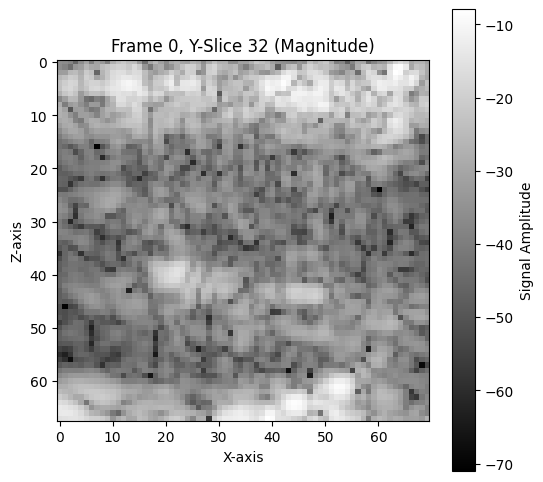

In [4]:
import matplotlib.pyplot as plt
frame0 = IQ[0]
mag = np.abs(frame0)
log_img = 20 * np.log10(mag / mag.max() + 1e-12)
# --- Visualization (Slicing the 3D Volume) ---
y_slice_index = mag.shape[1] // 2 
plt.figure(figsize=(6, 6))
plt.imshow(log_img[:, y_slice_index, :].T, cmap='gray')
plt.title(f"Frame 0, Y-Slice {y_slice_index} (Magnitude)")
plt.colorbar(label='Signal Amplitude')
plt.xlabel("X-axis")
plt.ylabel("Z-axis")
plt.show()

In [34]:
import ipywidgets as widgets
from IPython.display import display

vol = np.abs(IQ[0])

def view_slice(i):
    plt.figure(figsize=(5,5))
    plt.imshow(20*np.log10(vol[:, :, i] + 1e-6), cmap='gray')
    plt.title(f"Slice {i}")
    plt.colorbar(label='Signal Amplitude')
    plt.xlabel("Y-axis")
    plt.ylabel("X-axis")
    plt.show()

slider = widgets.IntSlider(0, 0, vol.shape[2]-1, 1)
widgets.interact(view_slice, i=slider)

interactive(children=(IntSlider(value=0, description='i', max=67), Output()), _dom_classes=('widget-interact',…

<function __main__.view_slice(i)>

In [33]:
!pip install matplotlib

In [15]:
print("Size:", f["PData/Size"][:].ravel())
print("Delta:", f["PData/PDelta"][:].ravel())
print("Origin:", f["PData/Origin"][:].ravel())

Size: [65. 70. 68.]
Delta: [0.76095779 0.76095779 0.5       ]
Origin: [-24.35064935 -26.25304383  19.        ]


NameError: name 'IQ' is not defined

In [7]:
f["#refs#"]

<HDF5 group "/#refs#" (1 members)>

In [1]:
!unzip "IQ_051_100.zip"

Archive:  IQ_051_100.zip
   creating: IQ_051_100/
  inflating: IQ_051_100/IQ051.mat    
  inflating: IQ_051_100/IQ052.mat    
  inflating: IQ_051_100/IQ053.mat    
  inflating: IQ_051_100/IQ054.mat    
  inflating: IQ_051_100/IQ055.mat    
  inflating: IQ_051_100/IQ056.mat    
  inflating: IQ_051_100/IQ057.mat    
  inflating: IQ_051_100/IQ058.mat    
  inflating: IQ_051_100/IQ059.mat    
  inflating: IQ_051_100/IQ060.mat    
  inflating: IQ_051_100/IQ061.mat    
  inflating: IQ_051_100/IQ062.mat    
  inflating: IQ_051_100/IQ063.mat    
  inflating: IQ_051_100/IQ064.mat    
  inflating: IQ_051_100/IQ065.mat    
  inflating: IQ_051_100/IQ066.mat    
  inflating: IQ_051_100/IQ067.mat    
  inflating: IQ_051_100/IQ068.mat    
  inflating: IQ_051_100/IQ069.mat    
  inflating: IQ_051_100/IQ070.mat    
  inflating: IQ_051_100/IQ071.mat    
  inflating: IQ_051_100/IQ072.mat    
  inflating: IQ_051_100/IQ073.mat    
  inflating: IQ_051_100/IQ074.mat    
  inflating: IQ_051_100/IQ075.mat    


main.py  test.ipynb


In [5]:
import os
os.listdir("/teamspace/uploads")

['.lightning_uploads']